In [ ]:
pip install tf_bodypix tfjs_graph_converter opencv-python matplotlib

INFO: pip is looking at multiple versions of tf-keras to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 72.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 69.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 33.8 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
  Attempting uninstall: tensorboard
    Found existing installation: t

In [ ]:
import tensorflow as tf
from tf_bodypix.api import download_model,load_model,BodyPixModelPaths
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tf_bodypix.draw import draw_poses
import math

In [ ]:
red = (0, 0, 255)  # Red
blue = (255, 0, 0)  # Blue
green = (0, 255, 0)  # Green

circle_radius = 10  # Adjust radius as needed
circle_thickness = 2  # Fill the circle

In [ ]:
bodypixmodel = load_model(download_model(BodyPixModelPaths.MOBILENET_FLOAT_50_STRIDE_16))

In [ ]:
body_parts_without_arms = [
    "left_face", "right_face", "torso_front", "torso_back",
    "left_upper_leg_front", "left_upper_leg_back",
    "right_upper_leg_front", "right_upper_leg_back",
    "left_lower_leg_front", "left_lower_leg_back",
    "right_lower_leg_front", "right_lower_leg_back",
    "left_foot", "right_foot"
]

In [ ]:
def generate_hip_width(image_path):
  image = tf.keras.preprocessing.image.load_img(image_path)
  # plt.imshow(image)
  image_array = tf.keras.preprocessing.image.img_to_array(image)
  result = bodypixmodel.predict_single(image_array)

  mask = result.get_mask(threshold=0.7).numpy().astype(np.uint8)

  image_colored = result.get_colored_part_mask(mask, part_names=body_parts_without_arms)

  poses = result.get_poses()

  image_with_poses = draw_poses(
    image_colored.copy(),
    poses,
    keypoints_color=(255, 100, 100),
    skeleton_color=(100, 100, 255)
  )

  # cv2_imshow(image_with_poses)

  rightHipPosition = poses[0].keypoints[12].position
  leftHipPosition = poses[0].keypoints[11].position

  # print(rightHipPosition)
  # print(leftHipPosition)

  temp_x = (rightHipPosition.x + leftHipPosition.x) / 2
  temp_y = (rightHipPosition.y + leftHipPosition.y) / 2

  average_x_position = int(temp_x)
  average_y_position = int(temp_y)

  experiment = image_colored.copy().astype(np.uint8)

  gray_image = cv2.cvtColor(experiment, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY)

  # visualize the binary image
  # cv2_imshow(thresh)

  if 0 <= average_y_position < thresh.shape[0]:
    # Find all x-coordinates where the pixel is white (255) at the specified y-coordinate (tempy)
    white_x_positions = np.where(thresh[average_y_position, :] == 255)[0]

    # Check if there are any white pixels in that row
    if white_x_positions.size > 0:
      leftmost_x = white_x_positions.min()
      rightmost_x = white_x_positions.max()

      image_result = image_colored.copy().astype(np.uint8)

      line_color = (0, 0, 255)  # Red color in BGR
      line_thickness = 2

      cv2.line(image_result, (leftmost_x, average_y_position), (rightmost_x, average_y_position), line_color, line_thickness)
      cv2.circle(image_result, (int(leftmost_x), int(average_y_position)), circle_radius, red, circle_thickness)
      cv2.circle(image_result, (int(rightmost_x), int(average_y_position)), circle_radius, red, circle_thickness)

      cv2_imshow(image_result)


      # cv2.waitKey(0)
      # cv2.destroyAllWindows()
    else:
      print("No white pixels found on the specified y-coordinate.")
  else:
    print("tempy is out of the image bounds.")
  return rightmost_x - leftmost_x
  cv2.destroyAllWindows()


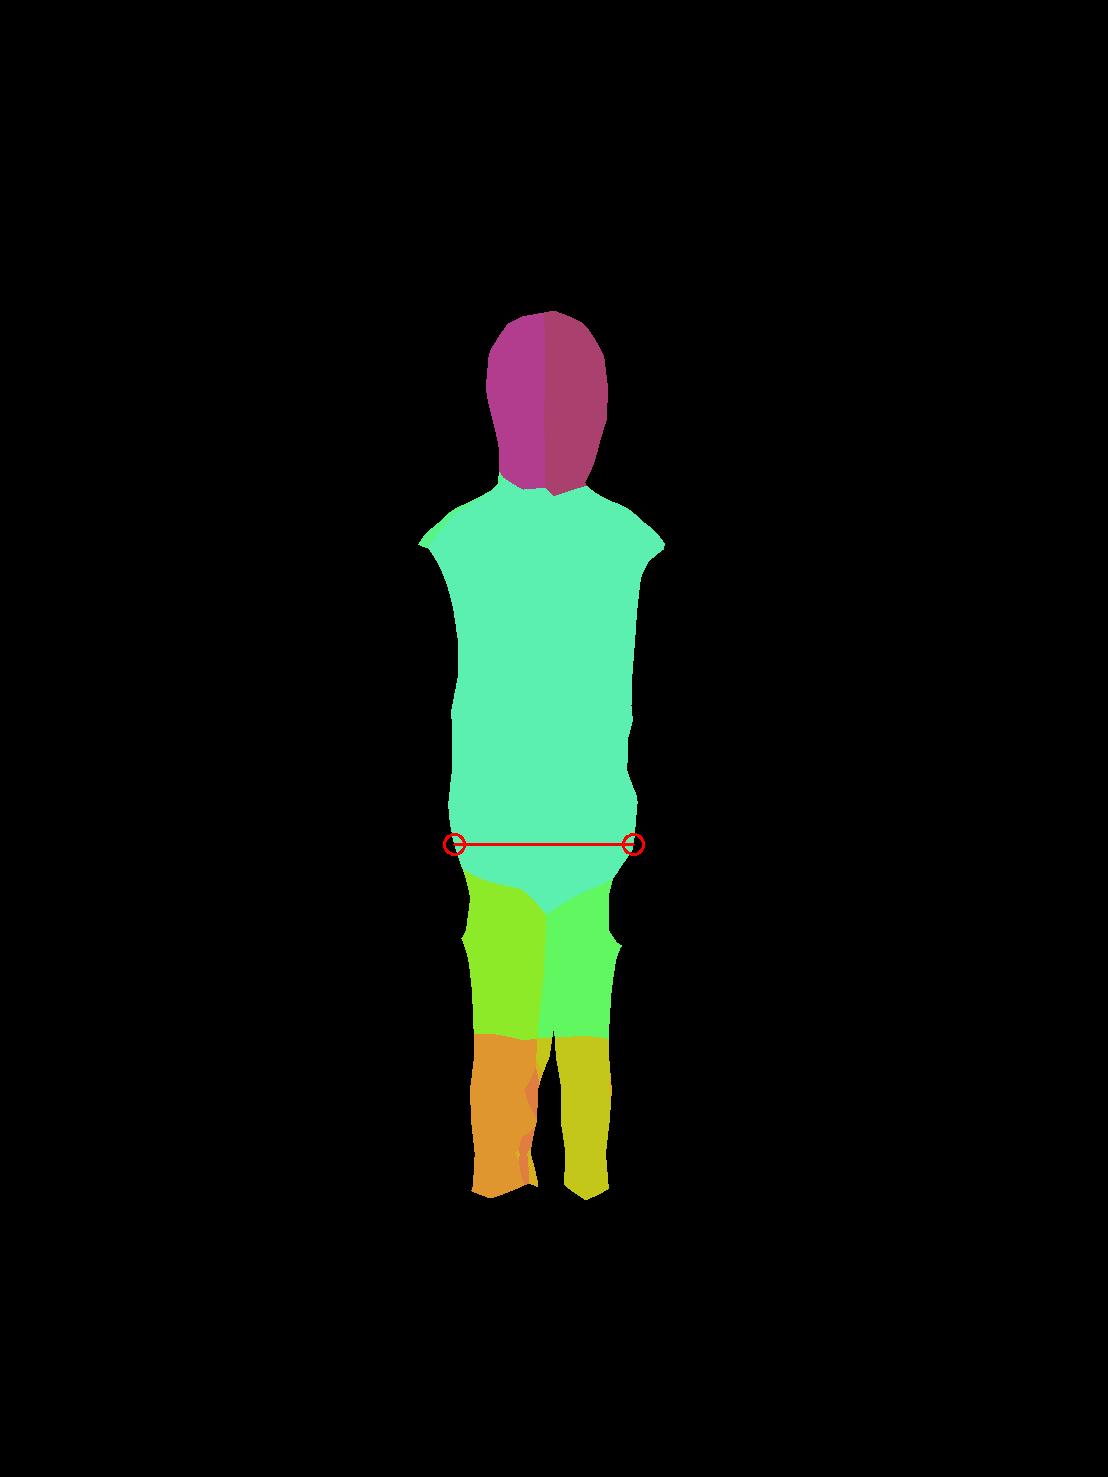

179

In [ ]:
generate_hip_width("./valen_depan.jpg")

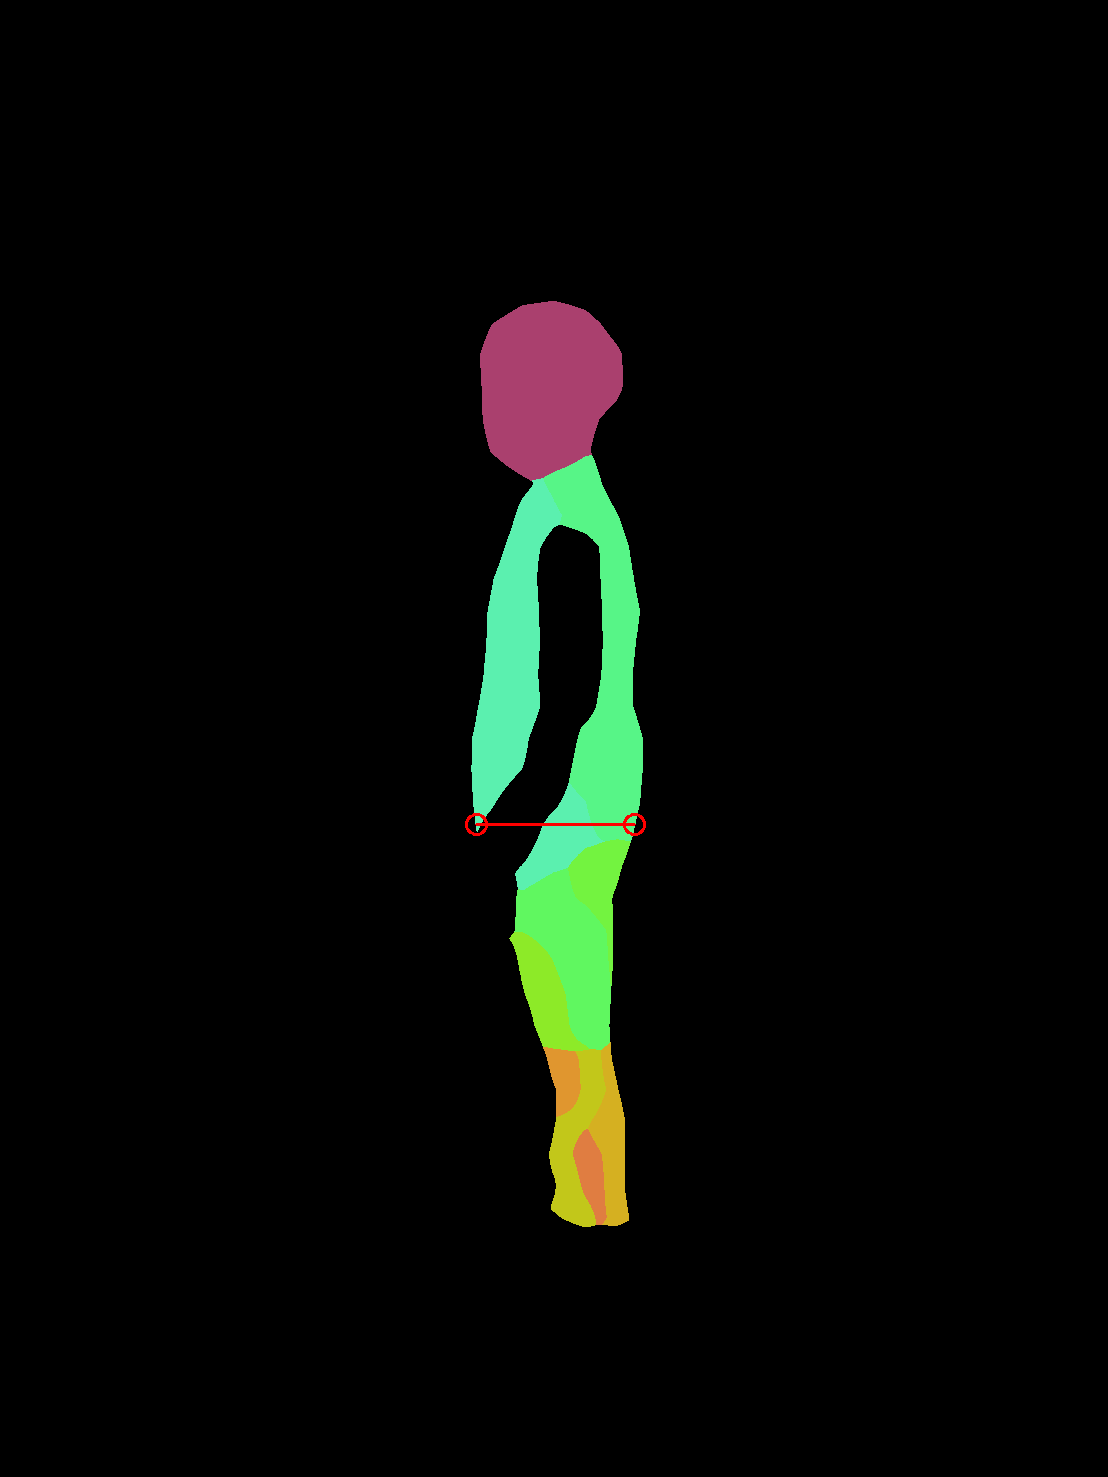

158

In [ ]:
generate_hip_width("./valen_samping.jpg")

In [ ]:
def generate_front_upper_leg_width(image_path):
  image = tf.keras.preprocessing.image.load_img(image_path)
  # plt.imshow(image)
  image_array = tf.keras.preprocessing.image.img_to_array(image)
  result = bodypixmodel.predict_single(image_array)

  mask = result.get_mask(threshold=0.7).numpy().astype(np.uint8)

  image_colored = result.get_colored_part_mask(mask, part_names=body_parts_without_arms)

  poses = result.get_poses()

  image_with_poses = draw_poses(
    image_colored.copy(),
    poses,
    keypoints_color=(255, 100, 100),
    skeleton_color=(100, 100, 255)
  )

  # cv2_imshow(image_with_poses)

  # print(poses[0].keypoints)

  rightHipPosition = poses[0].keypoints[12]
  rightKneePosition = poses[0].keypoints[14]

  tempxhip = rightHipPosition.position.x
  tempyhip = rightHipPosition.position.y

  tempxknee = rightKneePosition.position.x
  tempyknee = rightKneePosition.position.y

  upperRightLegX = int((tempxhip + tempxknee)/2)
  upperRightLegY = int((tempyhip + tempyknee)/2)

  delta_y_right = tempyhip - tempyknee
  delta_x_right = tempxhip - tempxknee
  gradienRight = abs(delta_x_right/delta_y_right)

  leftHipPosition = poses[0].keypoints[11]
  leftKneePosition = poses[0].keypoints[13]

  leftxhip = leftHipPosition.position.x
  leftyhip = leftHipPosition.position.y

  leftxknee = leftKneePosition.position.x
  leftyknee = leftKneePosition.position.y

  upperLeftLegX = int((leftxhip + leftxknee)/2)
  upperLeftLegY = int((leftyhip + leftyknee)/2)

  delta_y_left = leftyhip - leftyknee
  delta_x_left = leftxhip - leftxknee
  gradienLeft = abs(delta_x_left/delta_y_left)

  sides_hip_color = (0, 0, 255)  # Red
  average_hip_color = (255, 0, 0)  # Red

  circle_radius = 3
  circle_thickness = -1

  # Draw circles on the colored image
  image_with_circles = image_colored.copy().astype(np.uint8)
  cv2.circle(image_with_circles, (int(tempxhip), int(tempyhip)), circle_radius, sides_hip_color, circle_thickness)
  cv2.circle(image_with_circles, (int(tempxknee), int(tempyknee)), circle_radius, sides_hip_color, circle_thickness)
  cv2.circle(image_with_circles, (int(upperRightLegX), int(upperRightLegY)), circle_radius, sides_hip_color, circle_thickness)

  cv2.circle(image_with_circles, (int(leftxhip), int(leftyhip)), circle_radius, sides_hip_color, circle_thickness)
  cv2.circle(image_with_circles, (int(leftxknee), int(leftyknee)), circle_radius, sides_hip_color, circle_thickness)
  cv2.circle(image_with_circles, (int(upperLeftLegX), int(upperLeftLegY)), circle_radius, sides_hip_color, circle_thickness)

  cv2_imshow(image_with_circles)

  # for documentation purposes
  # experiment = image_with_circles

  print("gradien right: ", gradienRight)
  print("gradien left: ", gradienLeft)


  experiment = image_colored.copy().astype(np.uint8)

  image_to_be_drawn = image_colored.copy().astype(np.uint8)

  upperRightLegWidth = 0
  upperLeftLeg = 0

  if 0 <= upperRightLegY < experiment.shape[0]:

    currentColorRight = experiment[upperRightLegY][upperRightLegX]

    same_color_x_positions_right = np.where(experiment[upperRightLegY, :] == currentColorRight)[0]


    if same_color_x_positions_right.size > 0:
      leftmost_x = same_color_x_positions_right.min()
      rightmost_x = same_color_x_positions_right.max()

      # cv2.circle(experiment, (leftmost_x, upperRightLegY), circle_radius, blue, circle_thickness)
      # cv2.circle(experiment, (rightmost_x, upperRightLegY), circle_radius, blue, circle_thickness)


      line_color = (0, 0, 255)  # Red color in BGR
      line_thickness = 2
      valid_mostleft = []
      valid_mostright = []

      # print("correct y: ", upperRightLegY)
      # print("dari ", leftmost_x, " sampai ", rightmost_x)

      for x in range(leftmost_x, rightmost_x):
        y = int(upperRightLegY + (x - leftmost_x) * gradienRight)
        # print("hai: ", y)
        # print("nih: ", x, leftmost_x, rightmost_x)
        if 0 <= y < experiment.shape[0] and np.array_equal(experiment[y, x], currentColorRight):
          # print("masuk")
          if not valid_mostleft:
            cv2.circle(image_to_be_drawn, (int(x), int(y)), circle_radius, sides_hip_color, circle_thickness)
            valid_mostleft = [x,y]
          valid_mostright = [x,y]
          image_to_be_drawn[y, x] = line_color
        else:
          cv2.circle(image_to_be_drawn, (x, y), circle_radius, [0,0,0], circle_thickness)
          # print("salah: ", experiment[y, x], " banding dengan ", currentColorRight)
          # print("GA", 0 <= y < experiment.shape[0], np.array_equal(experiment[y, x], currentColorRight))
      if (valid_mostright):
        cv2.circle(image_to_be_drawn, (valid_mostright[0], valid_mostright[1]), circle_radius, sides_hip_color, circle_thickness)
        upperRightLegWidth = math.sqrt((valid_mostleft[0] - valid_mostright[0])**2 + (valid_mostleft[1] - valid_mostright[1])**2)
      # print(upperRightLegWidth)

      # cv2_imshow(experiment)
      # cv2_imshow(image_to_be_drawn)
    else:
      print("No white pixels found on the specified y-coordinate.")
  else:
    print("tempy is out of the image bounds.")

  if 0 <= upperLeftLegY < experiment.shape[0]:
    currentColorLeft = experiment[upperLeftLegY][upperLeftLegX]
    same_color_x_positions_left = np.where(experiment[upperLeftLegY, :] == currentColorLeft)[0]


    if same_color_x_positions_left.size > 0:
      # print("gradien nya ebrapa deh: ", gradienLeft)
      leftmost_x = same_color_x_positions_left.min()
      rightmost_x = same_color_x_positions_left.max()

      line_color = (0, 0, 255)  # Red color in BGR
      line_thickness = 2
      valid_mostleft = []
      valid_mostright = []

      for x in range(rightmost_x, leftmost_x, -1):
        y = int(upperLeftLegY - (x - rightmost_x) * gradienLeft)
        if 0 <= y < experiment.shape[0] and np.array_equal(experiment[y, x], currentColorLeft):
          if not valid_mostright:
            cv2.circle(image_to_be_drawn, (int(x), int(y)), circle_radius, sides_hip_color, circle_thickness)
            valid_mostright = [x,y]
          valid_mostleft = [x,y]
          # print("ukurannya nih boss", y, x)
          image_to_be_drawn[y, x] = line_color
      cv2.circle(image_to_be_drawn, (valid_mostleft[0], valid_mostleft[1]), circle_radius, sides_hip_color, circle_thickness)
      upperLeftLegWidth = math.sqrt((valid_mostleft[0] - valid_mostright[0])**2 + (valid_mostleft[1] - valid_mostright[1])**2)
      # print(upperLeftLegWidth)

      cv2_imshow(image_to_be_drawn)
    else:
      print("No white pixels found on the specified y-coordinate.")
  else:
    print("tempy is out of the image bounds.")

  # print("upper left leg width: ", upperLeftLegWidth)
  # print("upper right leg width: ", upperRightLegWidth)
  # print("average leg width: ", (upperLeftLegWidth + upperRightLegWidth)/2)
  return (upperLeftLegWidth + upperRightLegWidth) / 2
  # cv2.destroyAllWindows()


In [ ]:
generate_front_upper_leg_width("./vale_depan.jpg")

FileNotFoundError: [Errno 2] No such file or directory: './vale_depan.jpg'

In [ ]:
def get_leftEye_rightEye_color(poses, image_colored):

  image = image_colored.copy().astype(np.uint8)
  left_eye_position = poses[0].keypoints[1].position
  right_eye_position = poses[0].keypoints[2].position

  red = (0, 0, 255)  # Red
  blue = (255, 0, 0)  # Blue

  circle_radius = 10  # Adjust radius as needed
  circle_thickness = -1  # Fill the circle

  # Draw circles on the colored image
  image_with_circles = image.copy().astype(np.uint8)
  cv2.circle(image_with_circles, (int(left_eye_position.x), int(left_eye_position.y)), circle_radius, red, circle_thickness)
  cv2.circle(image_with_circles, (int(right_eye_position.x), int(right_eye_position.y)), circle_radius, blue, circle_thickness)

  # cv2_imshow(image_with_circles)
  return(image[int(left_eye_position.y), int(left_eye_position.x)], image[int(right_eye_position.y), int(right_eye_position.x)])



In [ ]:
def generate_side_leg(image_path_front, image_path_side):
  image = tf.keras.preprocessing.image.load_img(image_path_side)
  image_array = tf.keras.preprocessing.image.img_to_array(image)
  result = bodypixmodel.predict_single(image_array)
  mask = result.get_mask(threshold=0.7).numpy().astype(np.uint8)
  image_colored = result.get_colored_part_mask(mask, part_names=body_parts_without_arms)
  poses = result.get_poses()

  front_image = tf.keras.preprocessing.image.load_img(image_path_front)
  front_image_array = tf.keras.preprocessing.image.img_to_array(front_image)
  front_result = bodypixmodel.predict_single(front_image_array)
  front_mask = front_result.get_mask(threshold=0.5).numpy().astype(np.uint8)
  front_image_colored = front_result.get_colored_part_mask(front_mask, part_names=body_parts_without_arms)
  front_poses = front_result.get_poses()


  # Getting left and right face color
  left_eye_color, right_eye_color = get_leftEye_rightEye_color(front_poses, front_image_colored)
  # print("left eye color: ", left_eye_color)
  # print("right eye color: ", right_eye_color)

  # Decide which side our face heading
  left_count = 0
  right_count = 0

  half_height = int(image_colored.shape[0] // 2)

  for y in range(half_height):
    for x in range(image_colored.shape[1]):
      pixel_color = image_colored[y,x]
      if (pixel_color == left_eye_color).all():
        left_count += 1
      elif (pixel_color == right_eye_color).all():
        right_count += 1

  facing_left = True
  if left_count < right_count:
    facing_left = False

  # cv2_imshow(image_colored)

  if facing_left:
    leftHipPosition = poses[0].keypoints[11]
    leftKneePosition = poses[0].keypoints[13]
    # print(poses[0])

    leftxhip = leftHipPosition.position.x
    leftyhip = leftHipPosition.position.y

    leftxknee = leftKneePosition.position.x
    leftyknee = leftKneePosition.position.y

    upperLeftLegX = int((leftxhip + leftxknee)/2)
    upperLeftLegY = int((leftyhip + leftyknee)/2)

    delta_y_left = abs(leftyhip - leftyknee)
    delta_x_left = abs(leftxhip - leftxknee)
    gradienLeft = delta_x_left/delta_y_left
  else:
    # print("bener kok")
    rightHipPosition = poses[0].keypoints[12]
    rightKneePosition = poses[0].keypoints[14]

    tempxhip = rightHipPosition.position.x
    tempyhip = rightHipPosition.position.y

    tempxknee = rightKneePosition.position.x
    tempyknee = rightKneePosition.position.y

    upperRightLegX = int((tempxhip + tempxknee)/2)
    upperRightLegY = int((tempyhip + tempyknee)/2)

    delta_y_right = abs(tempyhip - tempyknee)
    delta_x_right = abs(tempxhip - tempxknee)
    gradienRight = delta_x_right/delta_y_right

  red = (0, 0, 255)  # Red
  blue = (255, 0, 0)  # Blue
  green = (0, 255, 0) # Green

  circle_radius = 10  # Adjust radius as needed
  circle_thickness = 2  # Fill the circle

  # Draw circles on the colored image
  # image_with_circles = image_colored.copy().astype(np.uint8)
  # cv2.circle(image_with_circles, (int(tempxhip), int(tempyhip)), circle_radius, sides_hip_color, circle_thickness)
  # cv2.circle(image_with_circles, (int(tempxknee), int(tempyknee)), circle_radius, sides_hip_color, circle_thickness)
  # cv2.circle(image_with_circles, (int(upperRightLegX), int(upperRightLegY)), circle_radius, sides_hip_color, circle_thickness)

  # print(rightHipPosition.position)
  # print(leftHipPosition.position)
  # cv2.circle(image_with_circles, (int(leftxhip), int(leftyhip)), circle_radius, average_hip_color, circle_thickness)
  # cv2.circle(image_with_circles, (int(leftxknee), int(leftyknee)), circle_radius, average_hip_color, circle_thickness)
  # cv2.circle(image_with_circles, (int(upperLeftLegX), int(upperLeftLegY)), circle_radius, average_hip_color, circle_thickness)

  # cv2_imshow(image_with_circles)

  experiment = image_colored.copy().astype(np.uint8)

  width = 0

  gray_image = cv2.cvtColor(experiment, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY)
  # cv2_imshow(thresh)

  if not facing_left:
    print('masuk sini kan')
    if 0 <= upperRightLegY < thresh.shape[0]:
      currentColorRight = experiment[upperRightLegY][upperRightLegX]

      same_color_x_positions_right = np.where(thresh[upperRightLegY, :] == 255)[0]

      if same_color_x_positions_right.size > 0:
        leftmost_x = same_color_x_positions_right.min()
        rightmost_x = same_color_x_positions_right.max()

        line_thickness = 2
        x = leftmost_x
        valid_mostleft = []
        valid_mostright = []
        counter = leftmost_x

        for x in range (leftmost_x, rightmost_x + (rightmost_x - leftmost_x)):
          y = int(upperRightLegY + (x - leftmost_x) * gradienRight)
          # print("test: ", thresh[y,x])
          if not 0 <= y < thresh.shape[0]:
            break
          if not 0 <= x < thresh.shape[1]:
            break
          if thresh[y, x] != 0:
            if not valid_mostleft:
              cv2.circle(experiment, (int(x), int(y)), circle_radius, red, circle_thickness)
              valid_mostleft = [x,y]
            valid_mostright = [x,y]
            experiment[y, x] = red
            # x += 1
        cv2.circle(experiment, (int(valid_mostright[0]), int(valid_mostright[1])), circle_radius, red, circle_thickness)
        result = math.sqrt((valid_mostleft[0] - valid_mostright[0])**2 + (valid_mostleft[1] - valid_mostright[1])**2)
        cv2_imshow(experiment)
      else:
        print("No white pixels found on the specified y-coordinate.")
    else:
      print("tempy is out of the image bounds.")
  else:
    # print("bener kok")
    if 0 <= upperLeftLegY < thresh.shape[0]:
      same_color_x_positions_left = np.where(thresh[upperLeftLegY, :] == 255)[0]

      if same_color_x_positions_left.size > 0:
        leftmost_x = same_color_x_positions_left.min()
        rightmost_x = same_color_x_positions_left.max()

        line_color = (0, 0, 255)  # Red color in BGR
        x = rightmost_x
        line_thickness = 2
        valid_mostleft = []
        valid_mostright = []
        for x in range (rightmost_x, leftmost_x - (rightmost_x - leftmost_x), -1):
          y = int(upperLeftLegY - (x - leftmost_x) * gradienLeft)
          if not 0 <= y < thresh.shape[0]:
            break
          if not 0 <= x < thresh.shape[1]:
            break
          if thresh[y, x] == 0:
            break
          if not valid_mostright:
            cv2.circle(experiment, (int(x), int(y)), circle_radius, red, circle_thickness)
            valid_mostright = [x,y]
          valid_mostleft = [x,y]
          experiment[y, x] = red
        cv2.circle(experiment, (int(valid_mostleft[0]), int(valid_mostleft[1])), circle_radius, red, circle_thickness)
        result = math.sqrt((valid_mostleft[0] - valid_mostright[0])**2 + (valid_mostleft[1] - valid_mostright[1])**2)
        cv2_imshow(experiment)
      else:
        print("No white pixels found on the specified y-coordinate.")
    else:
      print("tempy is out of the image bounds.")

  # print("width of side upper leg: ", result)
  return result
  # print("upper left leg width: ", upperLeftLegWidth)
  # print("upper right leg width: ", upperRightLegWidth)
  # print("average leg width: ", (upperLeftLegWidth + upperRightLegWidth)/2)
  # cv2.destroyAllWindows()


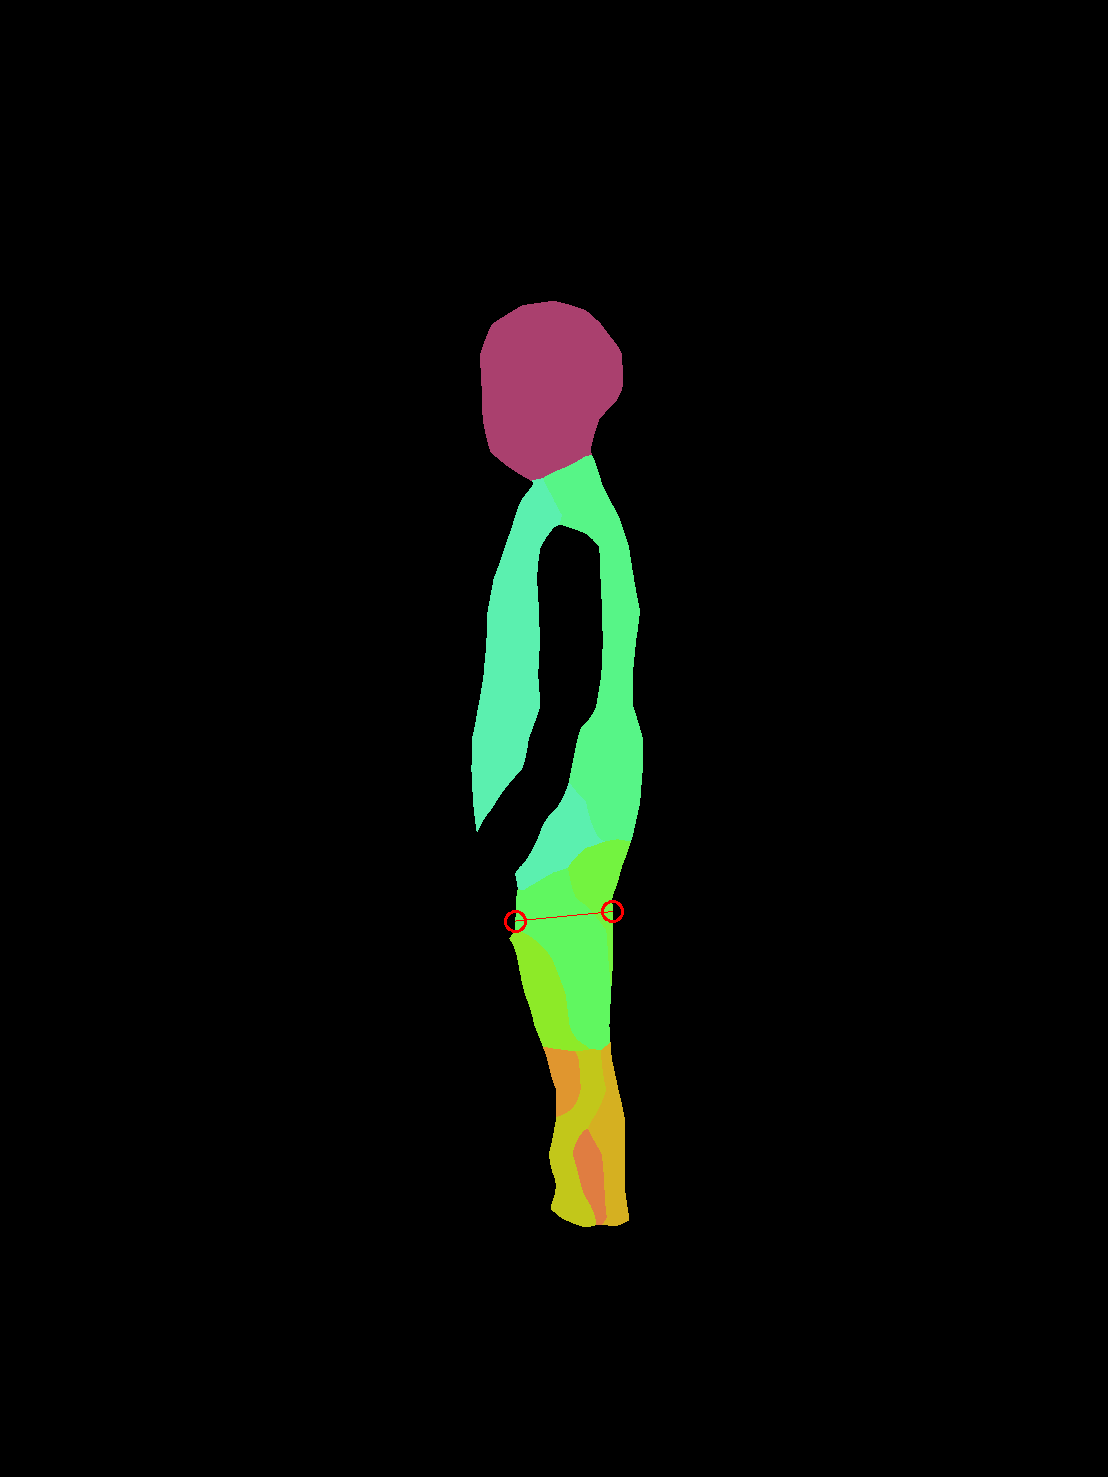

97.51410154434076

In [ ]:
generate_side_leg("valen_depan.jpg", "valen_samping.jpg")

In [ ]:
def generate_scale(image_path, real_height, facing_to):
  image = tf.keras.preprocessing.image.load_img(image_path)
  image_array = tf.keras.preprocessing.image.img_to_array(image)
  result = bodypixmodel.predict_single(image_array)
  mask = result.get_mask(threshold=0.7).numpy().astype(np.uint8)
  image_colored = result.get_colored_part_mask(mask, part_names=body_parts_without_arms)
  # cv2_imshow(mask)
  # cv2_imshow(image_colored)
  poses = result.get_poses()

  image_with_poses = draw_poses(
    image_array.copy(),  # create a copy to ensure we are not modifing the source image
    poses,
    keypoints_color=(255, 100, 100),
    skeleton_color=(100, 100, 255)
  )

  # cv2_imshow(image_with_poses)

  experiment = image_colored.copy().astype(np.uint8)
  gray_image = cv2.cvtColor(experiment, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray_image, 100, 255, cv2.THRESH_BINARY)

  # cv2_imshow(thresh)

  white_pixels = np.where(thresh == 255)
  max_x_white = 0
  max_y_white = 0
  if white_pixels[0].size > 0:
    top = np.argmin(white_pixels[0])
    max_x_white = white_pixels[1][top]
    max_y_white = white_pixels[0][top]

  lowest_point = 0
  # print(poses[0].keypoints[15].position.y)
  # print(poses[0].keypoints[16].position.y)
  ## Getting lowest point y value
  if facing_to == "left":
    lowest_point = poses[0].keypoints[15].position.y
  elif facing_to == "right":
    lowest_point = poses[0].keypoints[16].position.y
  else:
    lowest_point = (poses[0].keypoints[15].position.y + poses[0].keypoints[16].position.y) / 2
  print(lowest_point)

  red = [0, 0, 255]
  blue = [255, 0, 0]
  green = [0, 255, 0]

  circle_radius = 10
  circle_thickness = 2

  # print(left_ankle_position)
  # print(right_ankle_position)
  # Draw circles on the colored image

  # scale line from top to bottom
  image_with_circles = image_colored.copy().astype(np.uint8)
  cv2.circle(image_with_circles, (int(max_x_white), int(max_y_white)), circle_radius, blue, circle_thickness)
  cv2.circle(image_with_circles, (int(max_x_white), int(lowest_point)), circle_radius, blue, circle_thickness)
  cv2.line(image_with_circles,
         (int(max_x_white), int(max_y_white)),  # Start point of the line (center of the first circle)
         (int(max_x_white), int(lowest_point)),  # End point of the line (center of the second circle)
         red,  # Line color (you can define `green` as an RGB tuple, e.g., (0, 255, 0))
         2)



  # cv2.circle(image_with_circles, (int(max_x_white), int(poses[0].keypoints[15].position.y)), circle_radius, green, circle_thickness)
  # cv2.circle(image_with_circles, (int(max_x_white), int(poses[0].keypoints[16].position.y)), circle_radius, green, circle_thickness)
  cv2_imshow(image_with_circles)

  # print("highest: ", max_y_white)
  # print("lowest: ", lowest_point)
  return real_height / (lowest_point - max_y_white)



1264.6743388402415


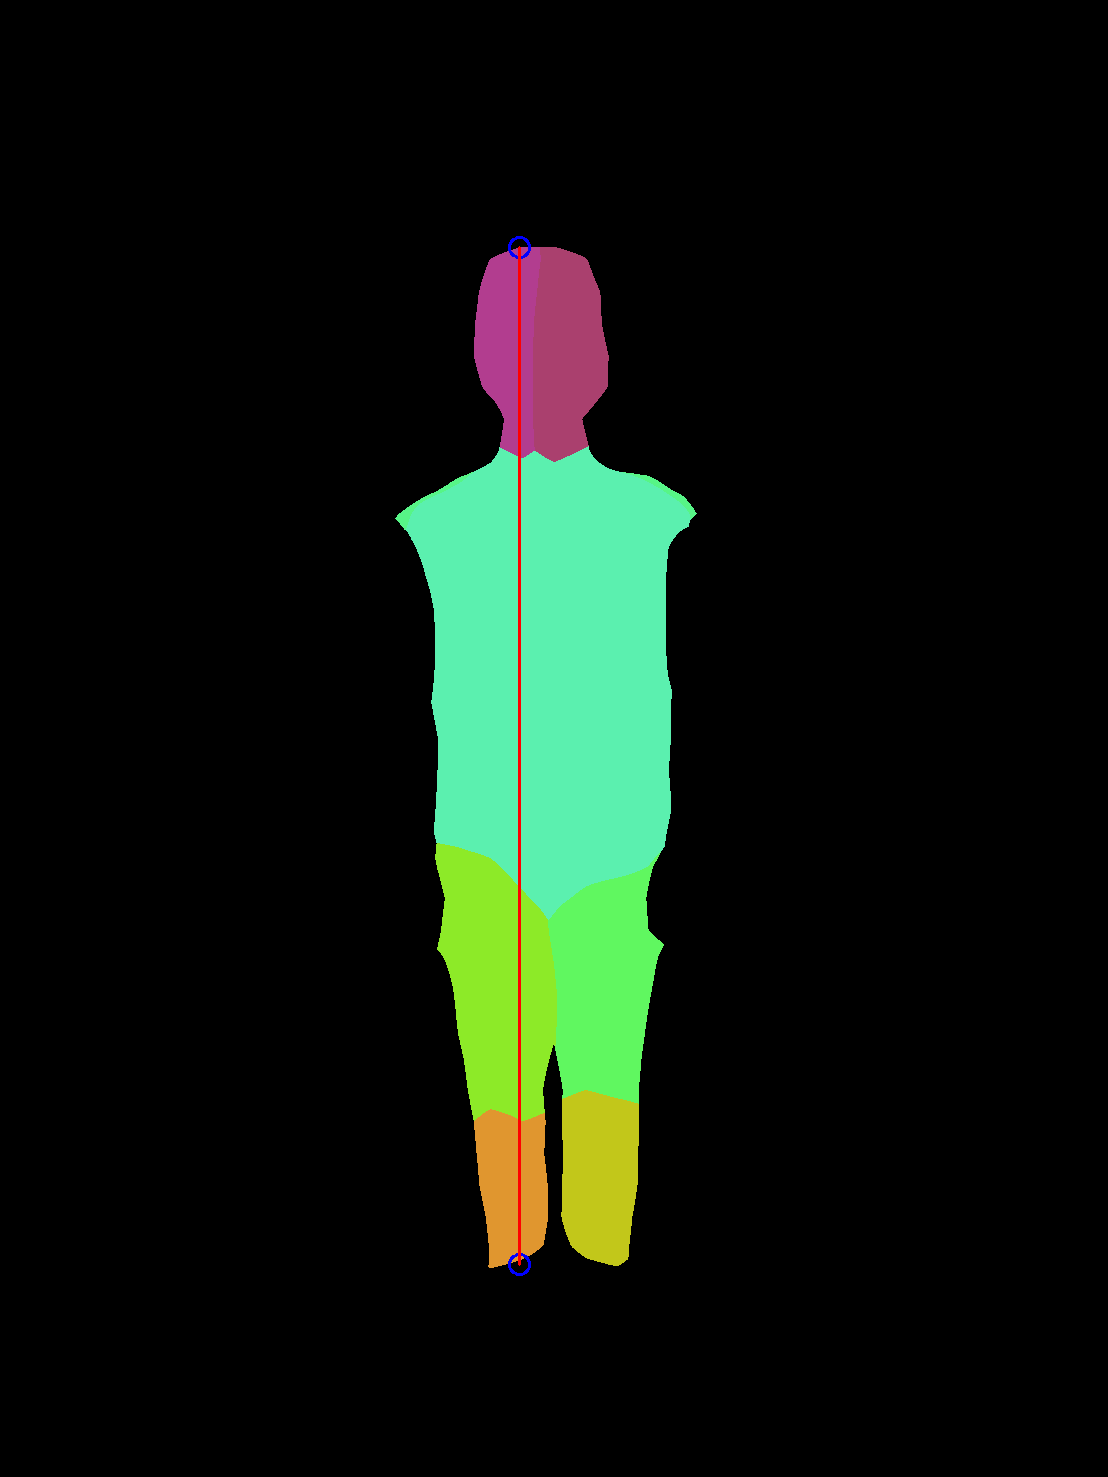

0.1670475450857244


In [ ]:
scale = generate_scale("./bapak_depan.jpg", 170, "")
print(scale)

In [ ]:
scale = generate_scale("./natan_samping.jpg", 168, "right")
print(scale)

1303.8314069802273
0.17894586690530076


In [ ]:
def generate_waist_height(image_path, gender):
  image = tf.keras.preprocessing.image.load_img(image_path)
  image_array = tf.keras.preprocessing.image.img_to_array(image)
  result = bodypixmodel.predict_single(image_array)
  mask = result.get_mask(threshold=0.7).numpy().astype(np.uint8)
  image_colored = result.get_colored_part_mask(mask, part_names=body_parts_without_arms)
  # cv2_imshow(mask)
  # cv2_imshow(image_colored)
  poses = result.get_poses()

  # print(poses)

  image_with_poses = draw_poses(
    image_array.copy(),  # create a copy to ensure we are not modifing the source image
    poses,
    keypoints_color=(255, 100, 100),
    skeleton_color=(100, 100, 255)
  )

  # cv2_imshow(image_with_poses)

  leftShoulder = poses[0].keypoints[5].position
  rightShoulder = poses[0].keypoints[6].position

  average_shoulder_x = (leftShoulder.x + rightShoulder.x) /2
  average_shoulder_y = (leftShoulder.y + rightShoulder.y) /2

  lowest_point = (poses[0].keypoints[15].position.y + poses[0].keypoints[16].position.y) / 2

  red = [0, 0, 255]
  blue = [255, 0, 0]
  green = [0, 255, 0]
  random = [0,255,255]

  circle_radius = 10
  circle_thickness = 2

  man_ratio = 1.5
  woman_ratio = 1.35

  waist_height = lowest_point - average_shoulder_y
  if gender == "man":
    waist_height /= man_ratio
    # print("masuk sini kan")
  else:
    waist_height /= woman_ratio

  # print(left_ankle_position)
  # print(right_ankle_position)
  # Draw circles on the colored image

  image_with_circles = image_colored.copy().astype(np.uint8)
  cv2.circle(image_with_circles, (int(average_shoulder_x), int(lowest_point - waist_height)), circle_radius, red, circle_thickness)
  cv2.circle(image_with_circles, (int(average_shoulder_x), int(lowest_point)), circle_radius, red, circle_thickness)
  # cv2.circle(image_with_circles, (int(leftShoulder.x), int(leftShoulder.y)), circle_radius, green, circle_thickness)
  # cv2.circle(image_with_circles, (int(rightShoulder.x), int(rightShoulder.y)), circle_radius, green, circle_thickness)
  # cv2.circle(image_with_circles, (int(rightShoulder.x), int(786.9606427920487)), circle_radius, red, circle_thickness)
  # cv2.circle(image_with_circles, (int(rightShoulder.x), int(poses[0].keypoints[11].position.y)), circle_radius, green, circle_thickness)

  cv2.line(
    image_with_circles,  # The image
    (int(average_shoulder_x), int(lowest_point - waist_height)),  # Starting point (average shoulder)
    (int(average_shoulder_x), int(lowest_point)),  # Ending point (lowest point)
    (255, 0, 0),  # Line color (blue in BGR format)
    thickness=2  # Line thickness
  )
  cv2_imshow(image_with_circles)

  # print("waist: ", waist_height)
  # print("lowest: ", lowest_point)
  return waist_height



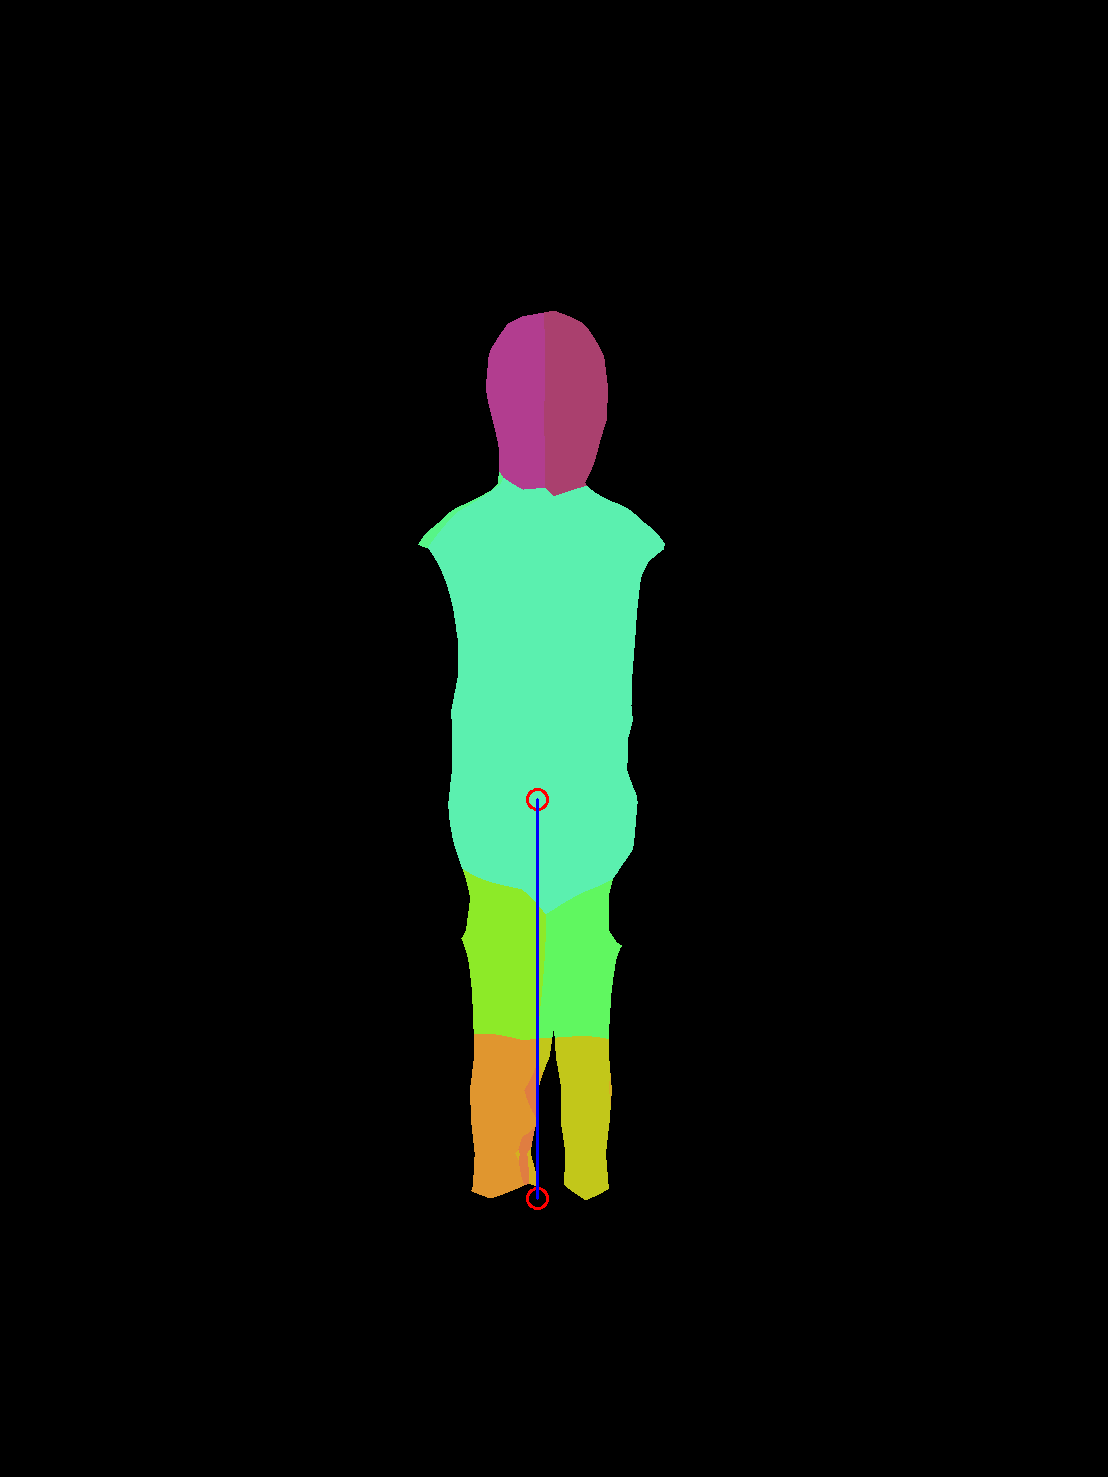

399.4523620316311

In [ ]:
generate_waist_height("valen_depan.jpg", "man")

In [ ]:
def generate_crotch_waist_height(image_path, waist_height):
  image = tf.keras.preprocessing.image.load_img(image_path)
  image_array = tf.keras.preprocessing.image.img_to_array(image)
  result = bodypixmodel.predict_single(image_array)
  mask = result.get_mask(threshold=0.7).numpy().astype(np.uint8)
  image_colored = result.get_colored_part_mask(mask, part_names=body_parts_without_arms)
  # cv2_imshow(image_colored)
  poses = result.get_poses()

  # print(poses)

  image_with_poses = draw_poses(
    image_array.copy(),  # create a copy to ensure we are not modifing the source image
    poses,
    keypoints_color=(255, 100, 100),
    skeleton_color=(100, 100, 255)
  )

  # cv2_imshow(image_with_poses)


  rightHipPosition = poses[0].keypoints[12]
  rightKneePosition = poses[0].keypoints[14]

  tempxhip = rightHipPosition.position.x
  tempyhip = rightHipPosition.position.y

  tempxknee = rightKneePosition.position.x
  tempyknee = rightKneePosition.position.y

  upperRightLegX = int((tempxhip + tempxknee)/2)
  upperRightLegY = int((tempyhip + tempyknee)/2)

  leftHipPosition = poses[0].keypoints[11]
  leftKneePosition = poses[0].keypoints[13]

  leftxhip = leftHipPosition.position.x
  leftyhip = leftHipPosition.position.y

  leftxknee = leftKneePosition.position.x
  leftyknee = leftKneePosition.position.y

  upperLeftLegX = int((leftxhip + leftxknee)/2)
  upperLeftLegY = int((leftyhip + leftyknee)/2)

  lowest_point = (poses[0].keypoints[15].position.y + poses[0].keypoints[16].position.y) / 2

  upperLeftLegColor = image_colored[int(upperLeftLegY), int(upperLeftLegX)]
  upperRightLegColor = image_colored[int(upperRightLegY), int(upperRightLegX)]
  hipColor = image_colored[int((poses[0].keypoints[11].position.y + poses[0].keypoints[11].position.y)/2),
                           int((poses[0].keypoints[12].position.x + poses[0].keypoints[12].position.x)/2)]

  matches = np.where(
    (image_colored[:, :, 0] == hipColor[0]) &  # Match Blue (if using BGR)
    (image_colored[:, :, 1] == hipColor[1]) &  # Match Green
    (image_colored[:, :, 2] == hipColor[2])    # Match Red
  )

  matching_coordinates = list(zip(matches[1], matches[0]))  # (x, y)
  image_with_circles = image_colored.copy().astype(np.uint8)

  red = [0,0,255]
  blue = [255,0,0]

  # Find the lowest y-coordinate and the corresponding x-coordinate
  if matching_coordinates:
    lowest_x, lowest_y = max(matching_coordinates, key=lambda coord: coord[1])  # Sort by y
    cv2.circle(image_with_circles, (int(lowest_x), int(lowest_y)), 10, [0,0,255], 2)
    result = lowest_y - (lowest_point - waist_height)
    cv2.circle(image_with_circles, (int(lowest_x), int(lowest_point- waist_height)), 10, red, 2)
    cv2.circle(image_with_circles, (int(lowest_x), int(lowest_y)), 10, red, 2)
    cv2.line(
      image_with_circles,  # The image
      (int(lowest_x), int(lowest_point - waist_height)),  # Starting point (average shoulder)
      (int(lowest_x), int(lowest_y)),  # Ending point (lowest point)
      (255, 0, 0),  # Line color (blue in BGR format)
      thickness=2  # Line thickness
    )

    cv2_imshow(image_with_circles)
    return result
  else:
    print("No matching pixels found.")





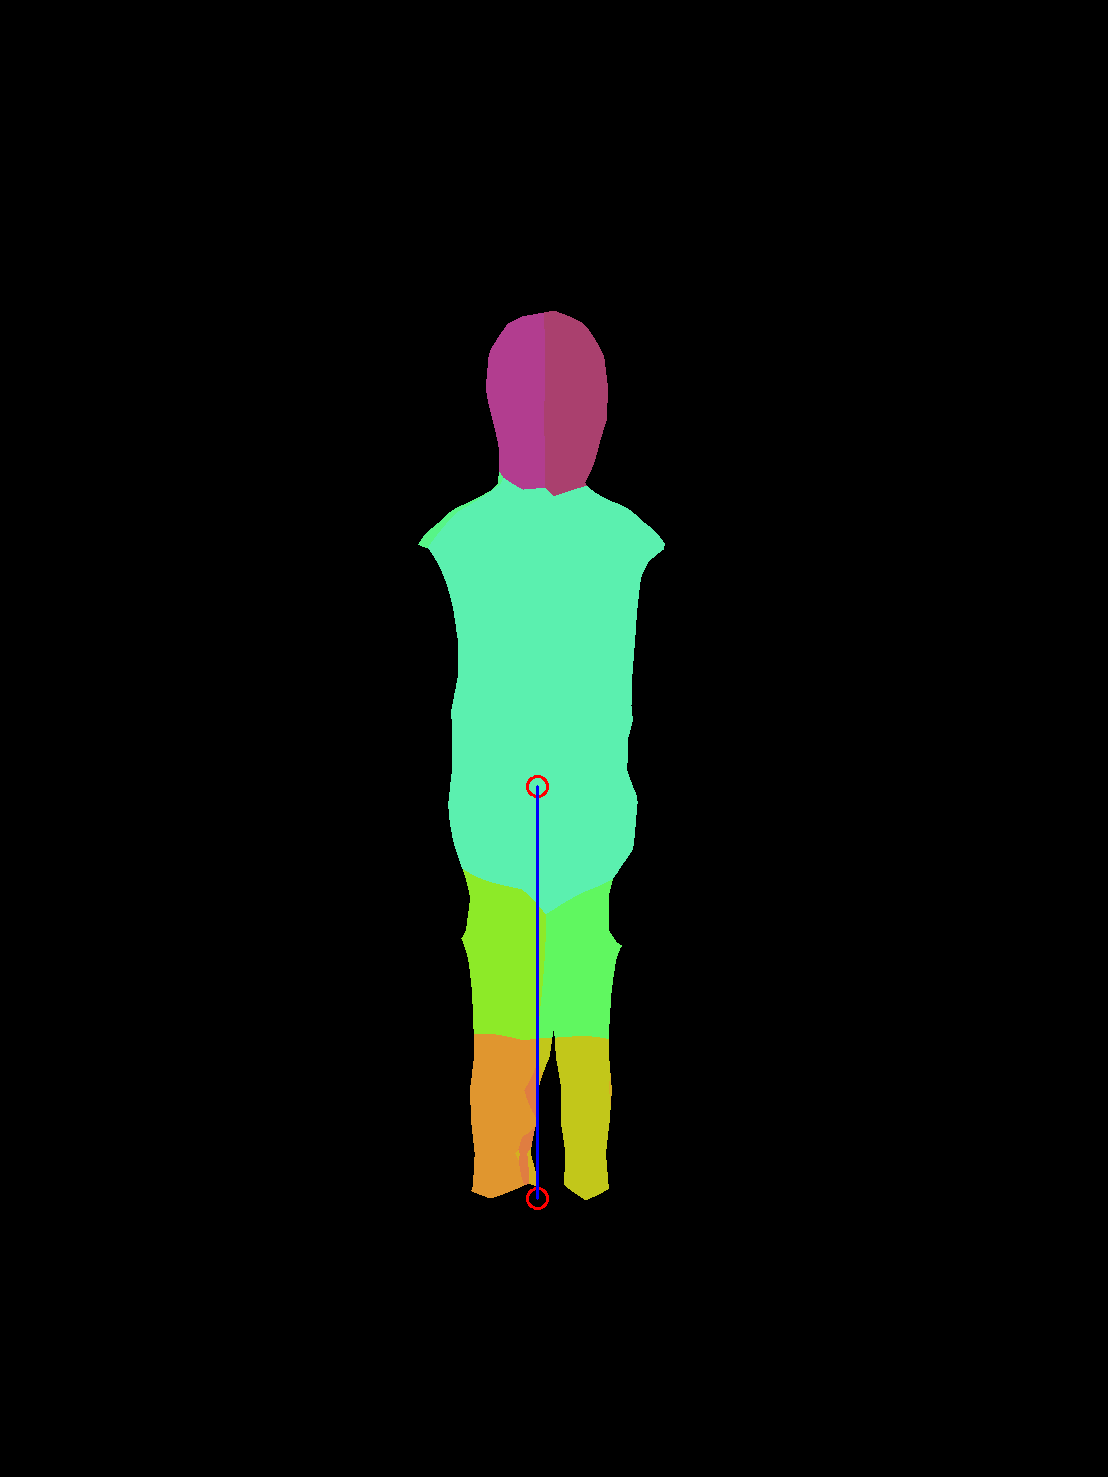

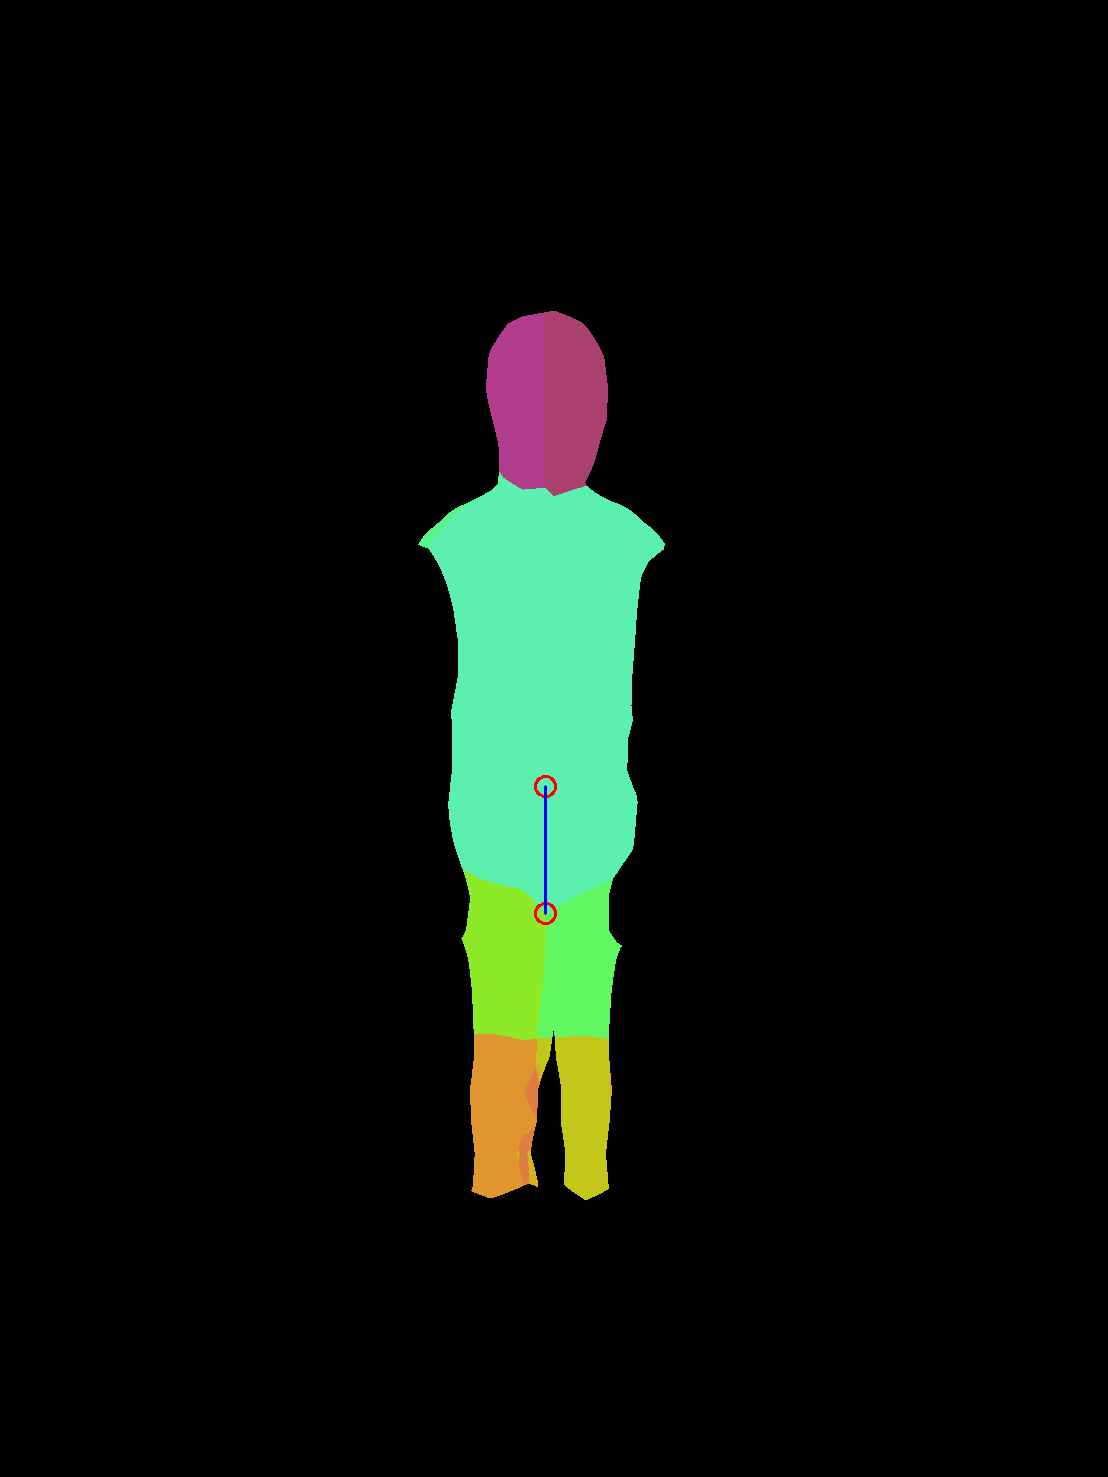

126.0393572079513

In [ ]:
waist_height = generate_waist_height("valen_depan.jpg", "man")
generate_crotch_waist_height("valen_depan.jpg", waist_height)

In [ ]:
def generate_waist_width(image_path, gender):
  image = tf.keras.preprocessing.image.load_img(image_path)
  # plt.imshow(image)
  image_array = tf.keras.preprocessing.image.img_to_array(image)
  result = bodypixmodel.predict_single(image_array)

  mask = result.get_mask(threshold=0.7).numpy().astype(np.uint8)

  image_colored = result.get_colored_part_mask(mask, part_names=body_parts_without_arms)

  poses = result.get_poses()

  image_with_poses = draw_poses(
    image_colored.copy(),
    poses,
    keypoints_color=(255, 100, 100),
    skeleton_color=(100, 100, 255)
  )

  # cv2_imshow(image_with_poses)

  lowest_point = (poses[0].keypoints[15].position.y + poses[0].keypoints[16].position.y) / 2
  waist_height = generate_waist_height(image_path, gender)
  waist_y = int(lowest_point - waist_height)

  experiment = image_colored.copy().astype(np.uint8)

  gray_image = cv2.cvtColor(experiment, cv2.COLOR_BGR2GRAY)
  ret, thresh = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY)

  # visualize the binary image
  # cv2_imshow(thresh)

  if 0 <= waist_y < thresh.shape[0]:
    # Find all x-coordinates where the pixel is white (255) at the specified y-coordinate (tempy)
    white_x_positions = np.where(thresh[waist_y, :] == 255)[0]

    # Check if there are any white pixels in that row
    if white_x_positions.size > 0:
      leftmost_x = white_x_positions.min()
      rightmost_x = white_x_positions.max()

      image_with_line = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)  # Convert to BGR to draw a colored line
      line_color = (0, 0, 255)  # Red color in BGR
      line_thickness = 2

      cv2.line(image_with_line, (leftmost_x, waist_y), (rightmost_x, waist_y), line_color, line_thickness)

      cv2_imshow(image_with_line)
      # cv2.waitKey(0)
      # cv2.destroyAllWindows()
    else:
      print("No white pixels found on the specified y-coordinate.")
  else:
    print("tempy is out of the image bounds.")
  return rightmost_x - leftmost_x
  cv2.destroyAllWindows()


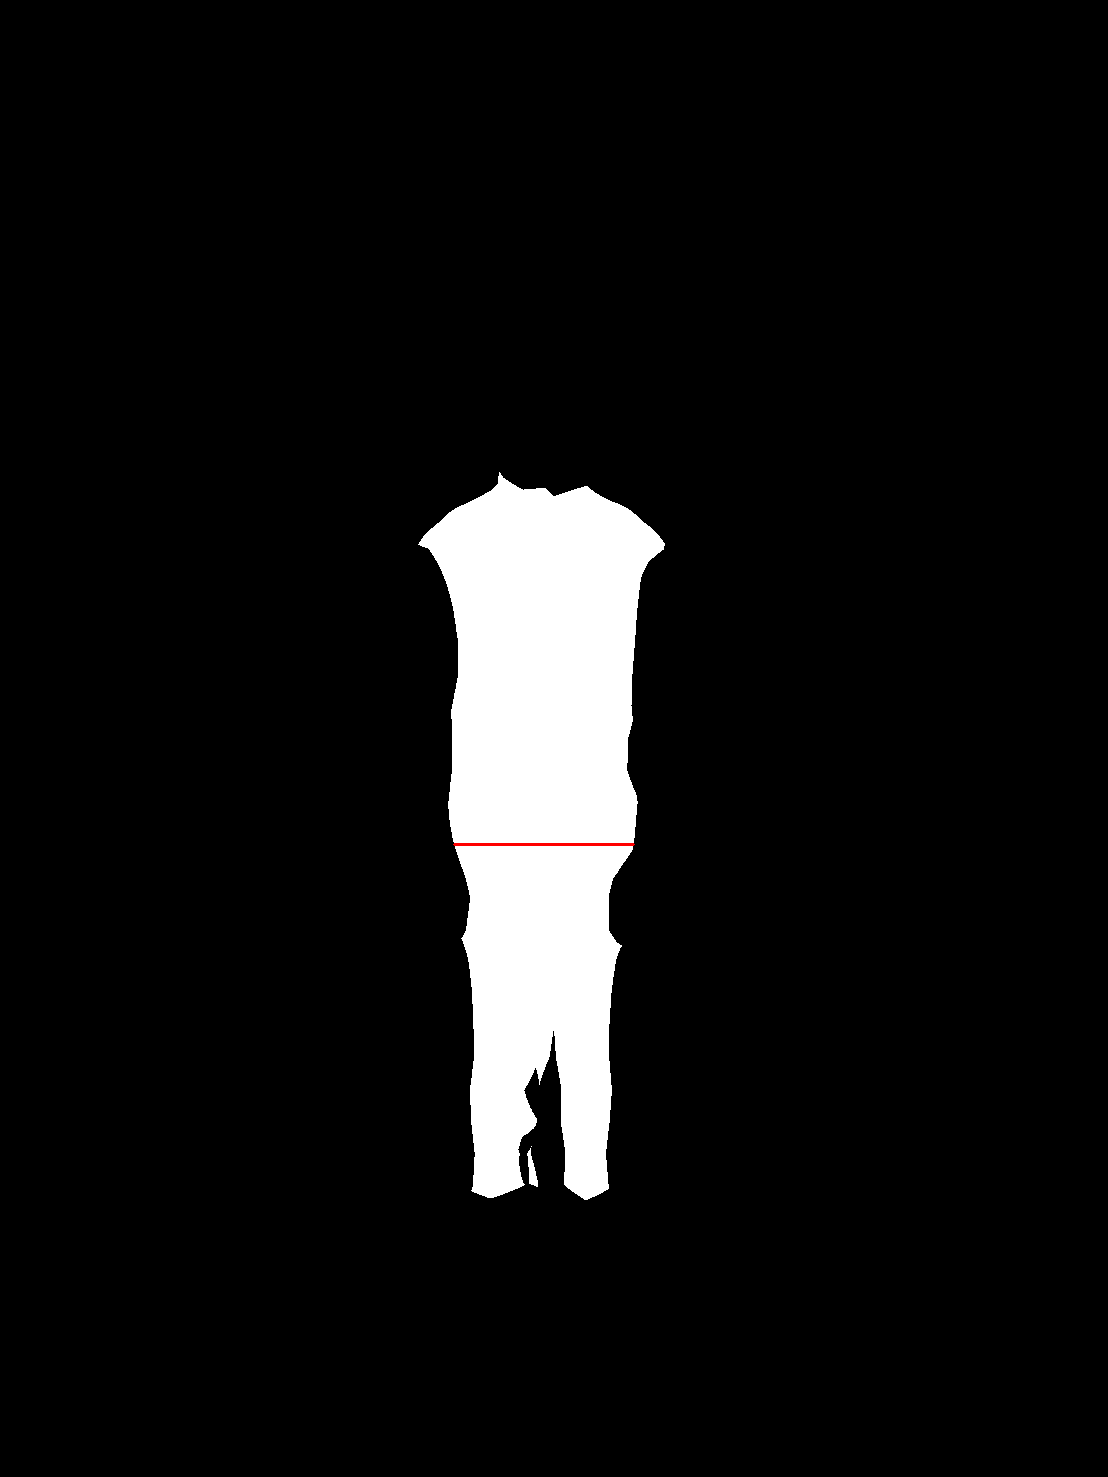

179

In [ ]:
generate_hip_width("valen_depan.jpg")

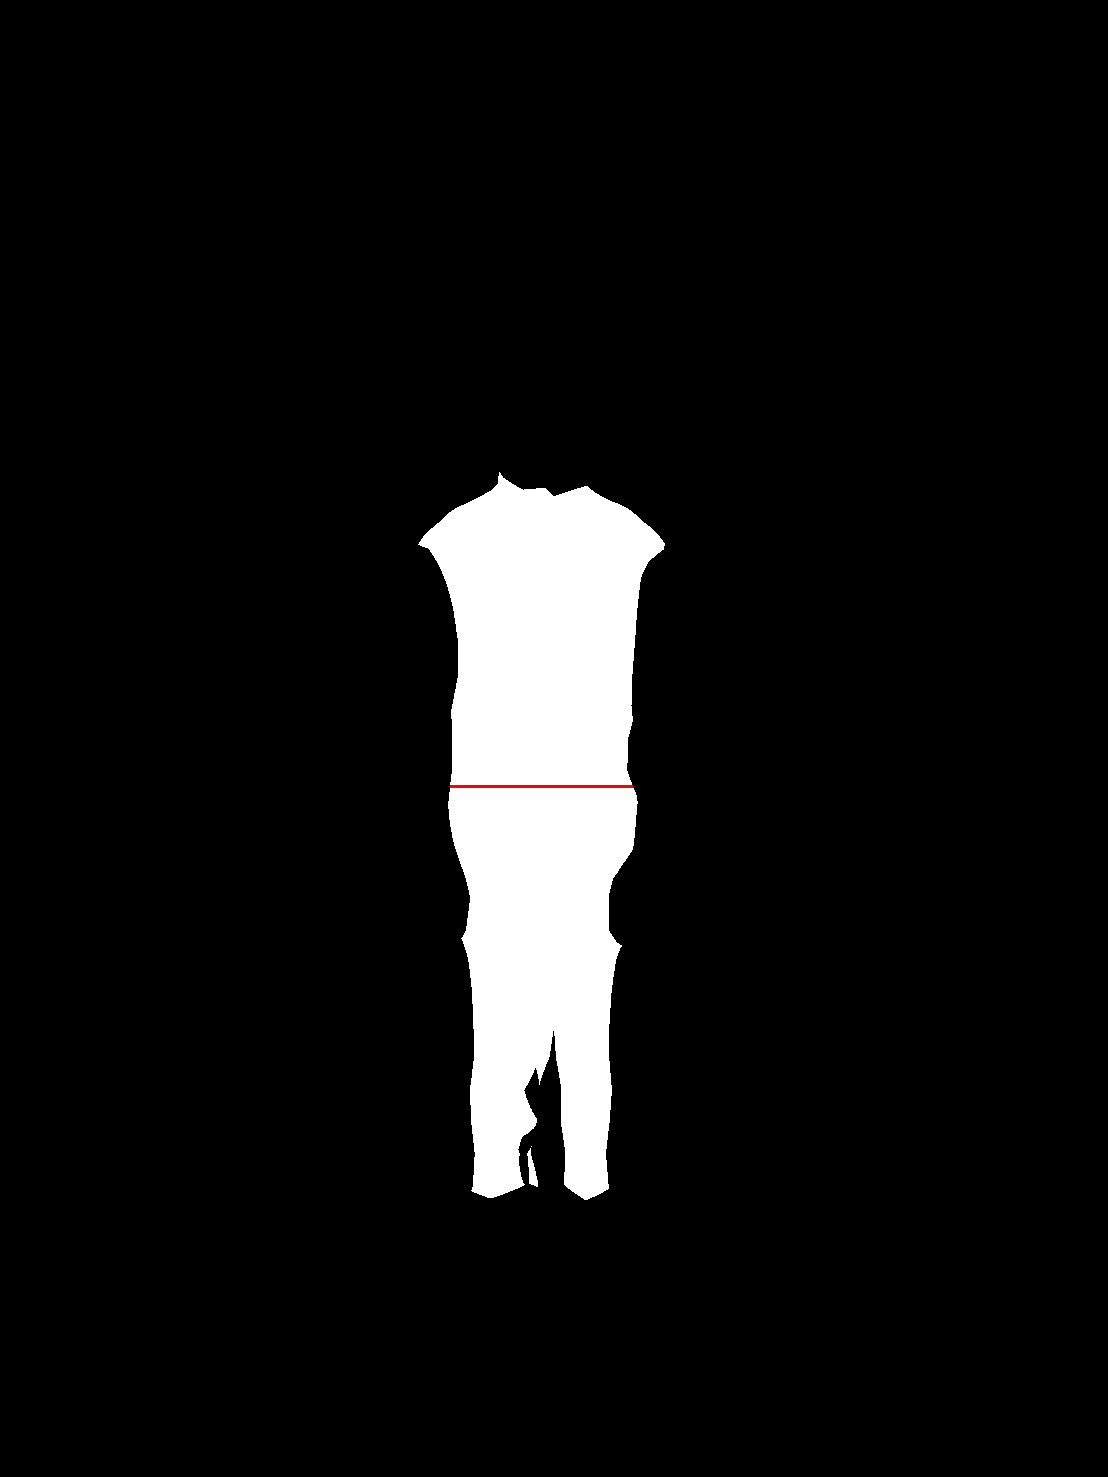

182

In [ ]:
generate_waist_width("valen_depan.jpg", "man")

In [ ]:
generate_waist_height("./otin_depan.jpg", "man")

1302.9253010685115
1309.7434897105761
masuk sini kan


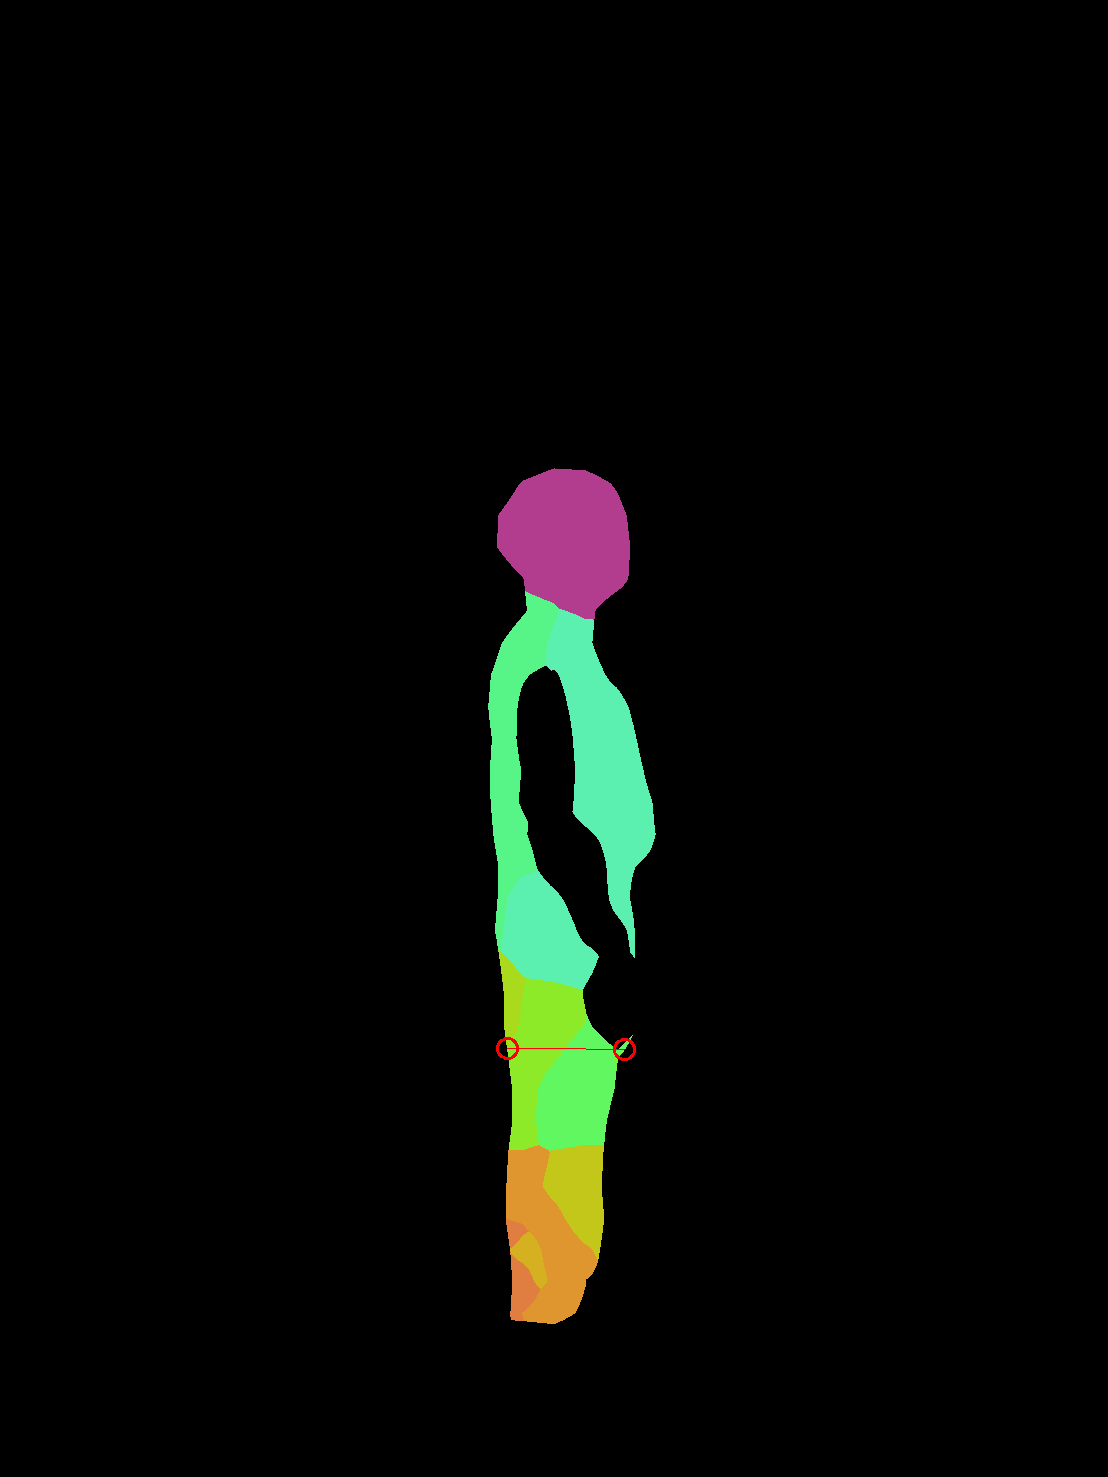

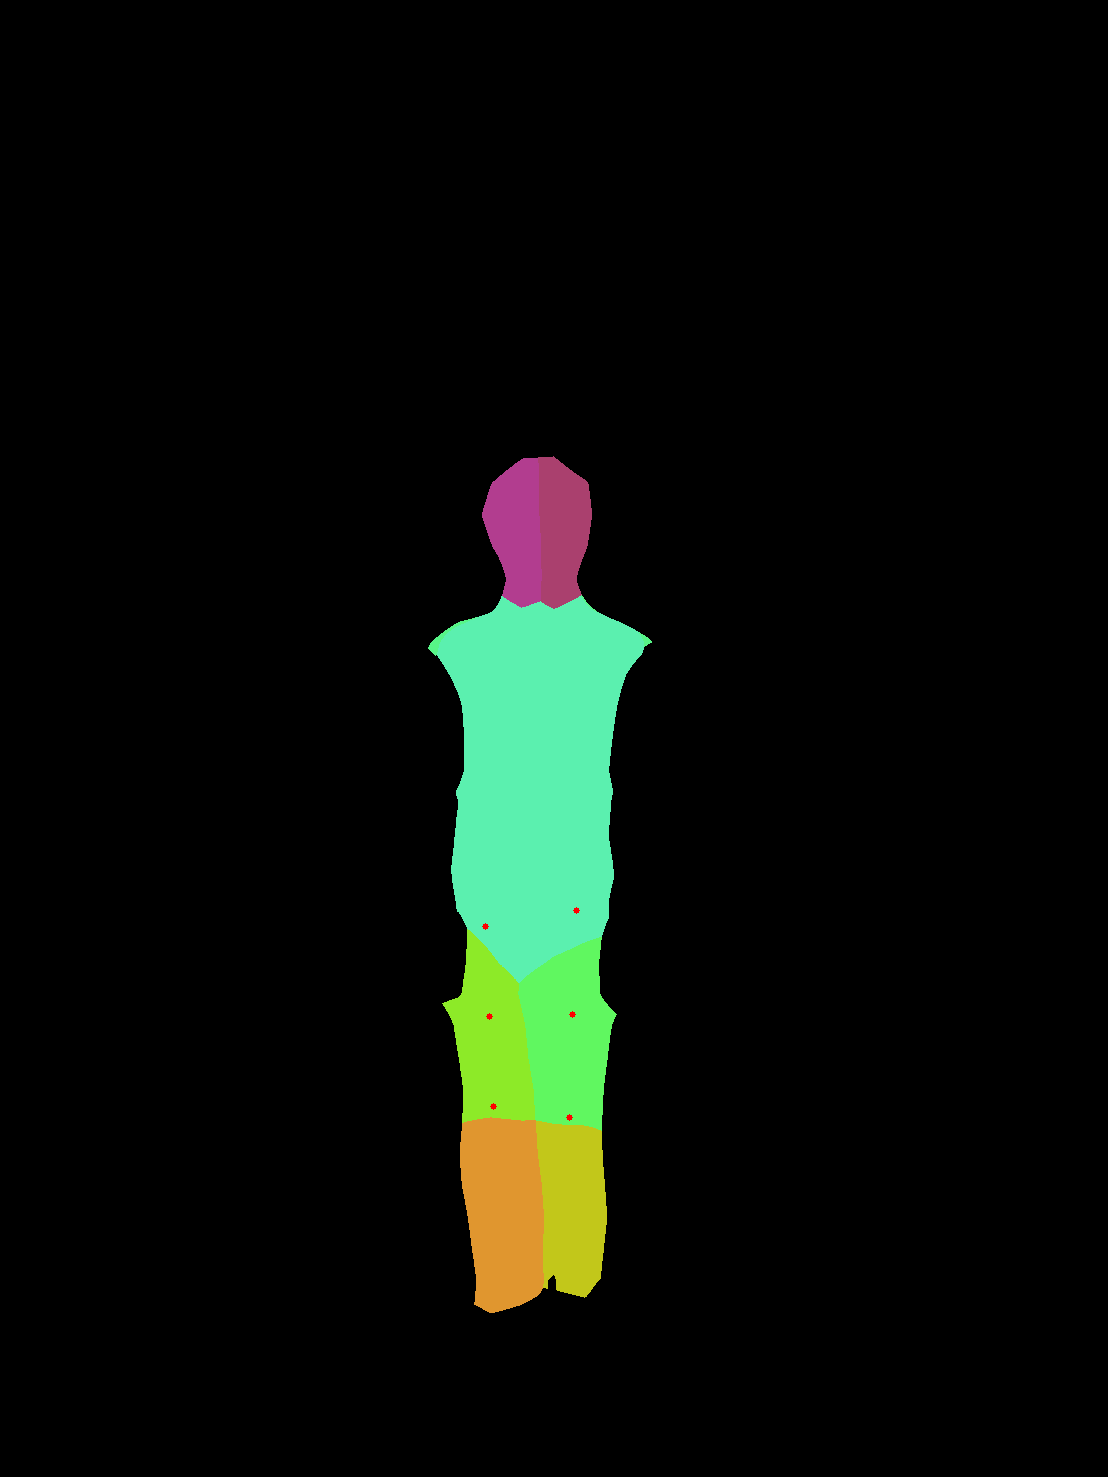

gradien right:  0.04436936015288544
gradien left:  0.036085630875835016


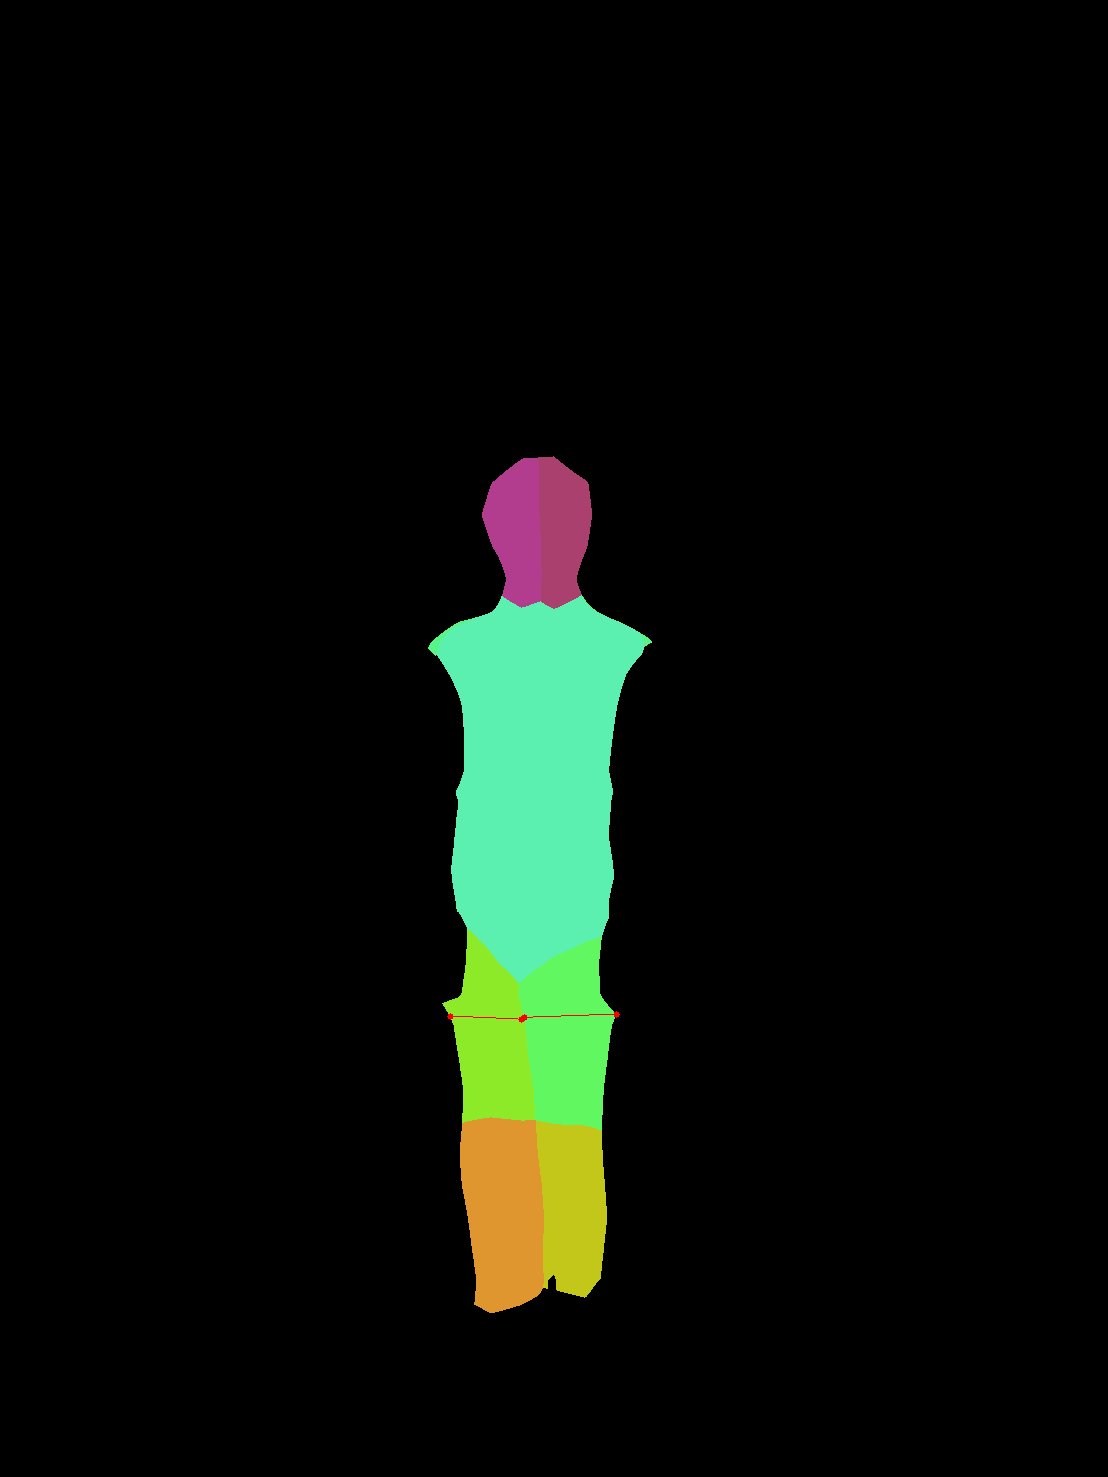

front leg width:  81.55612603275291
front leg width:  117.00427342623003


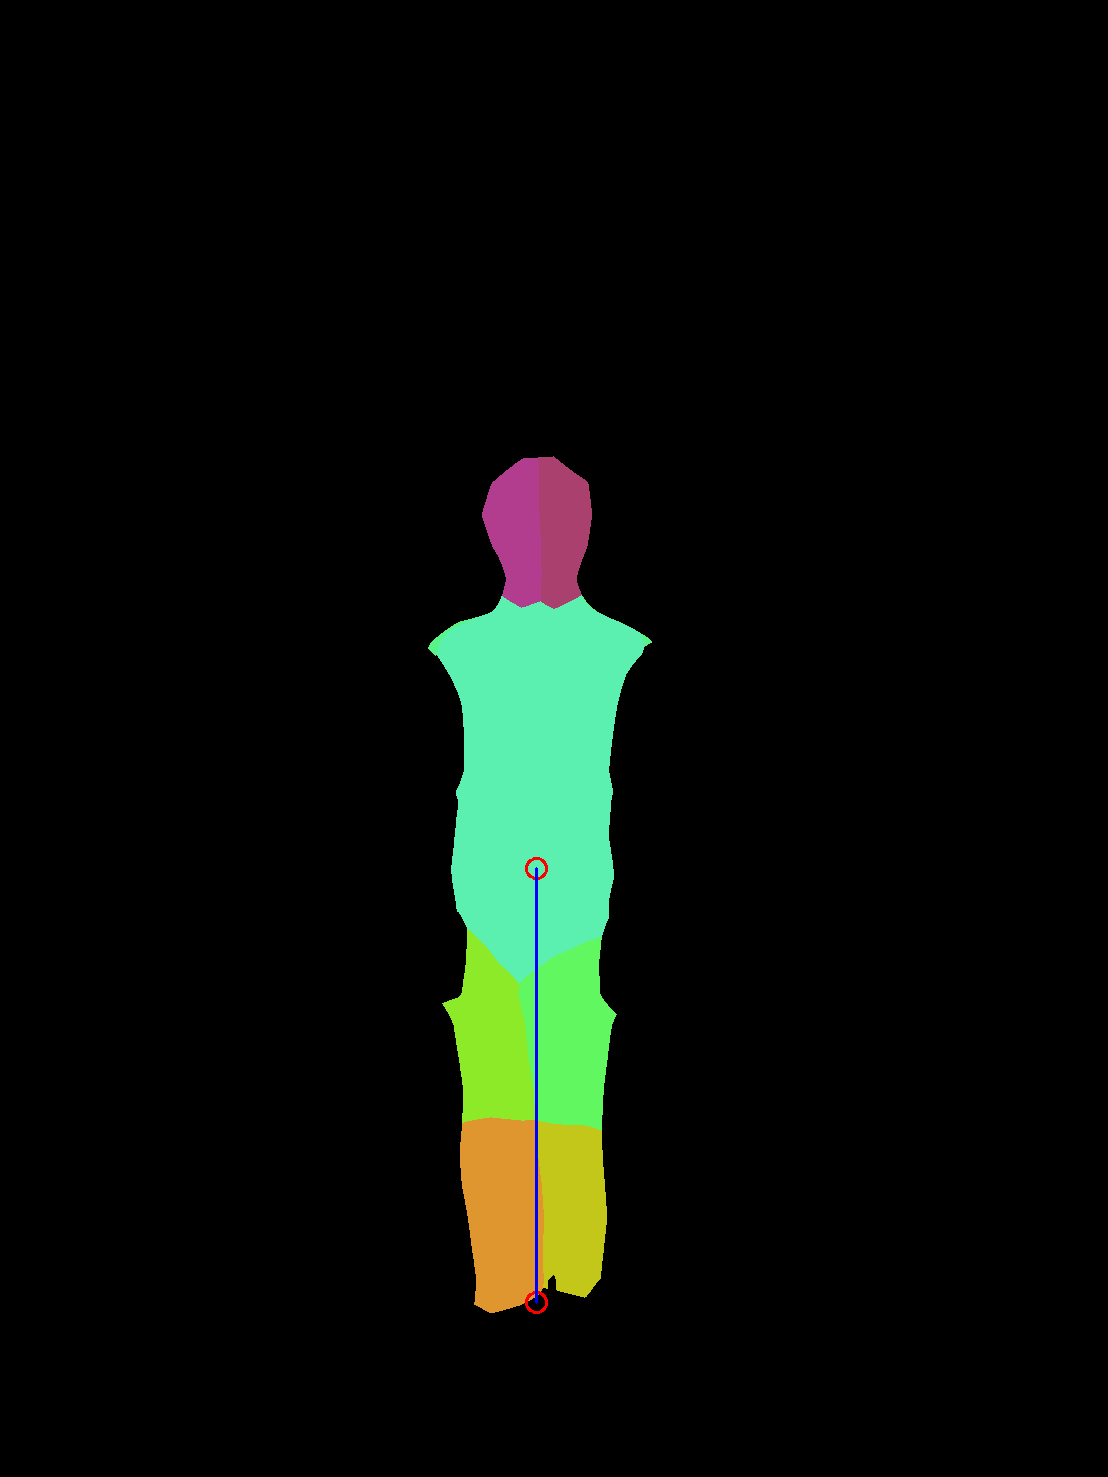

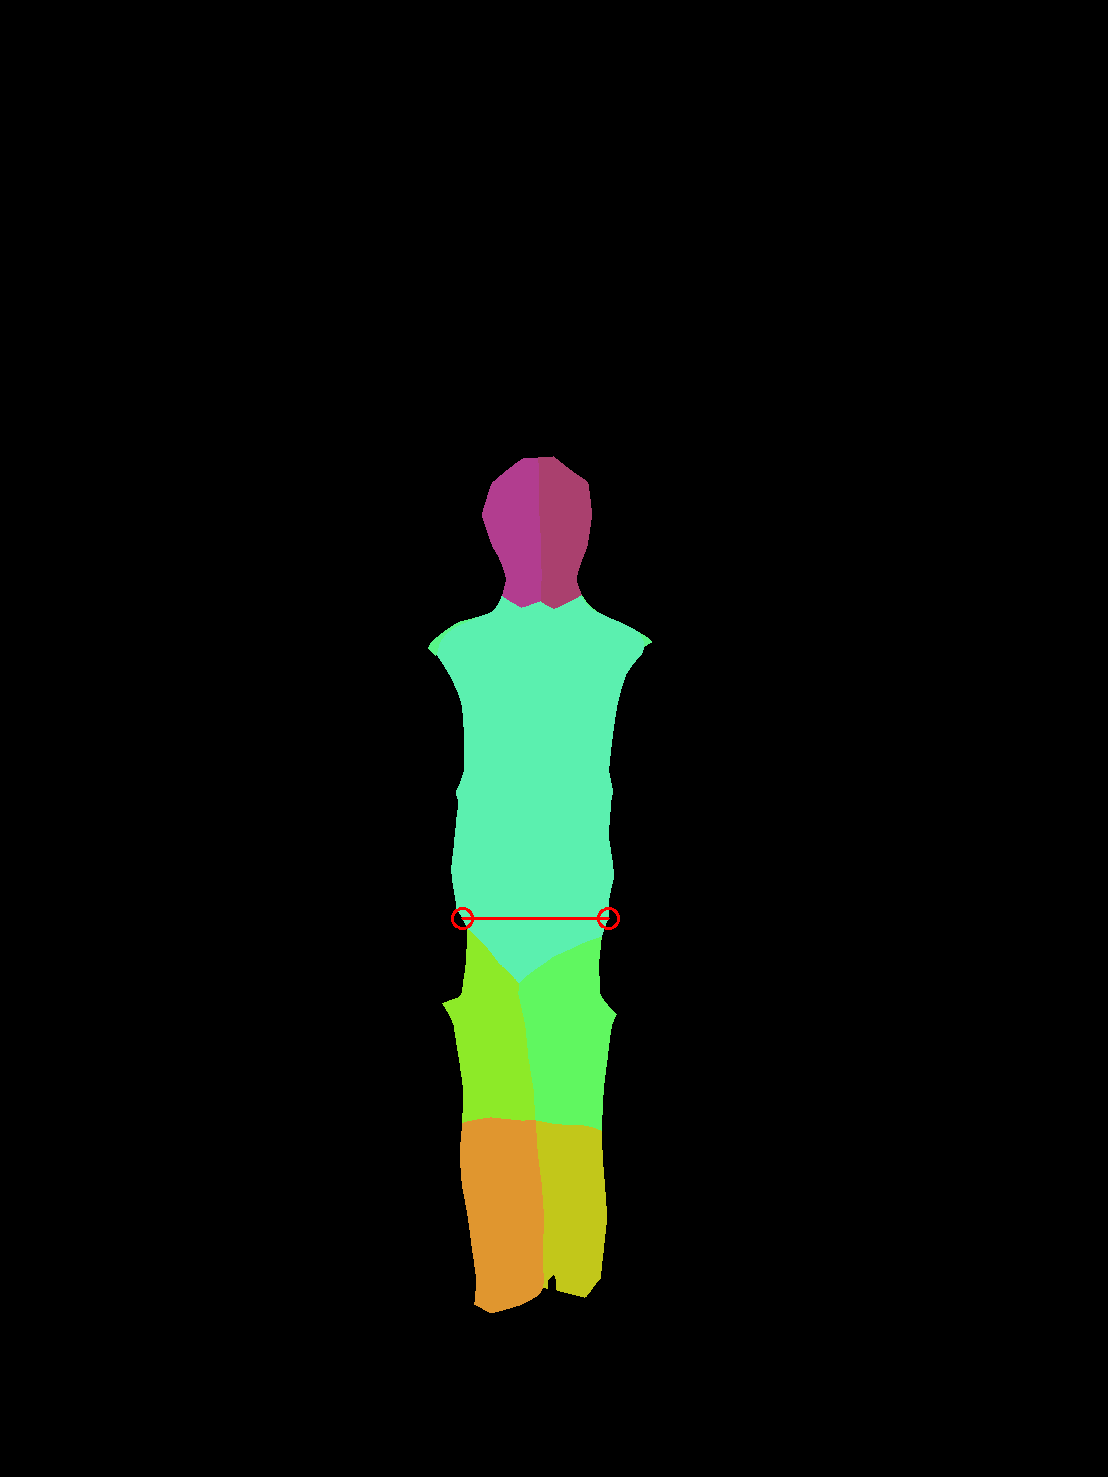

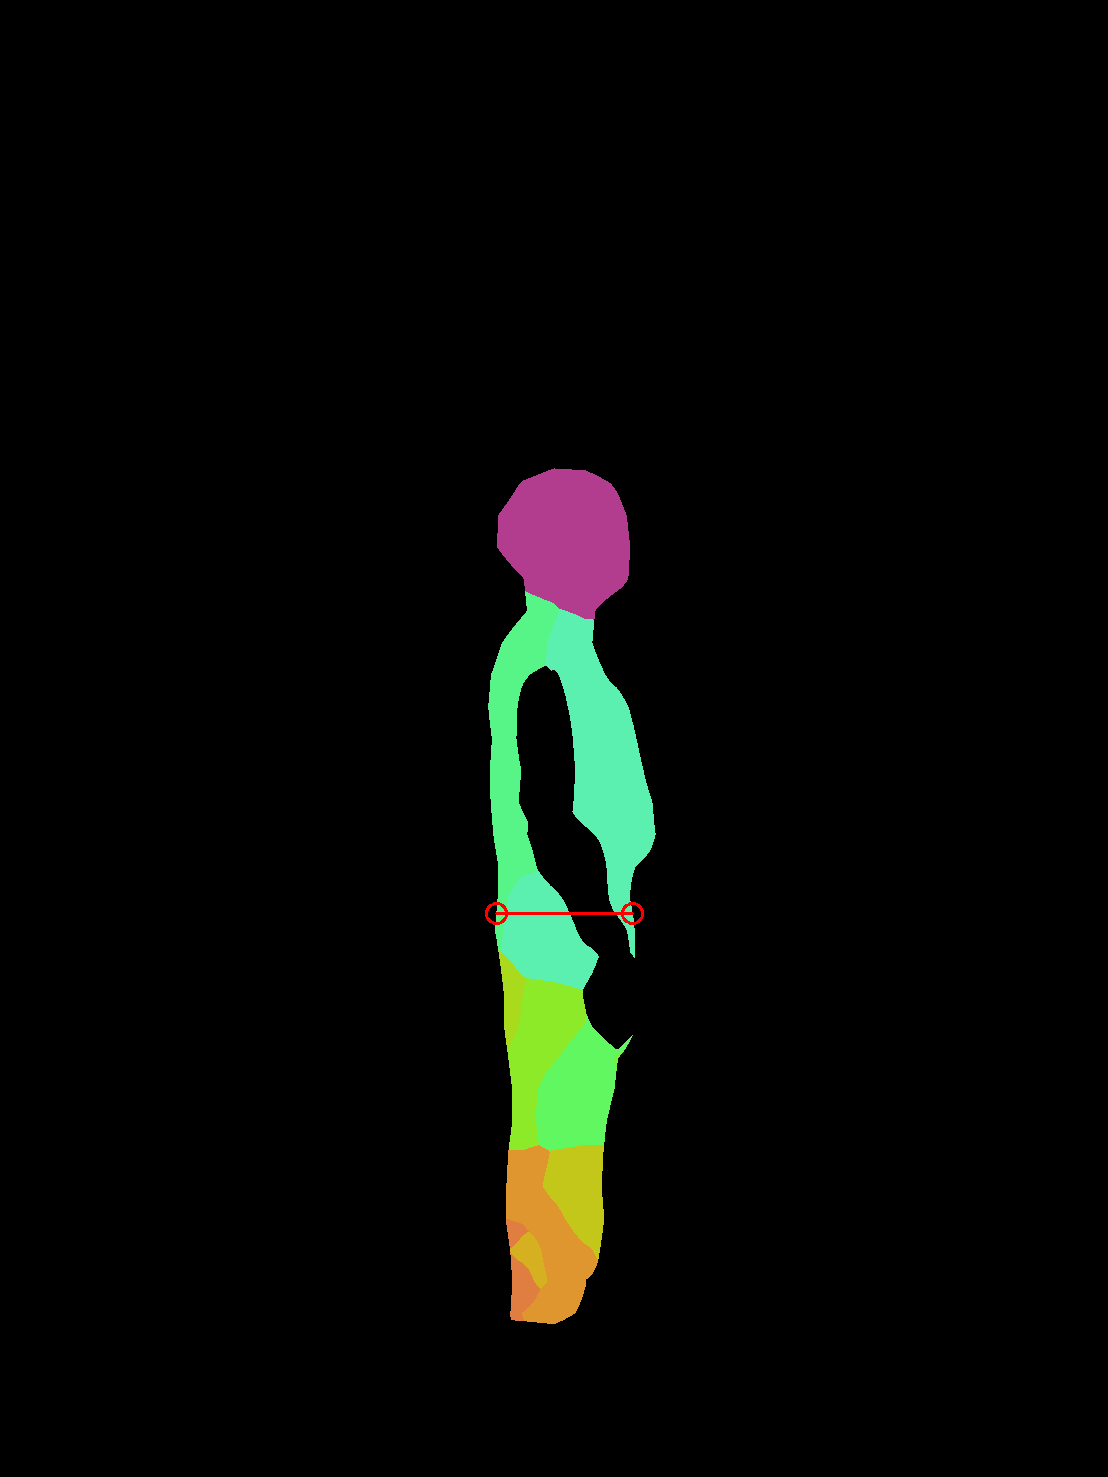

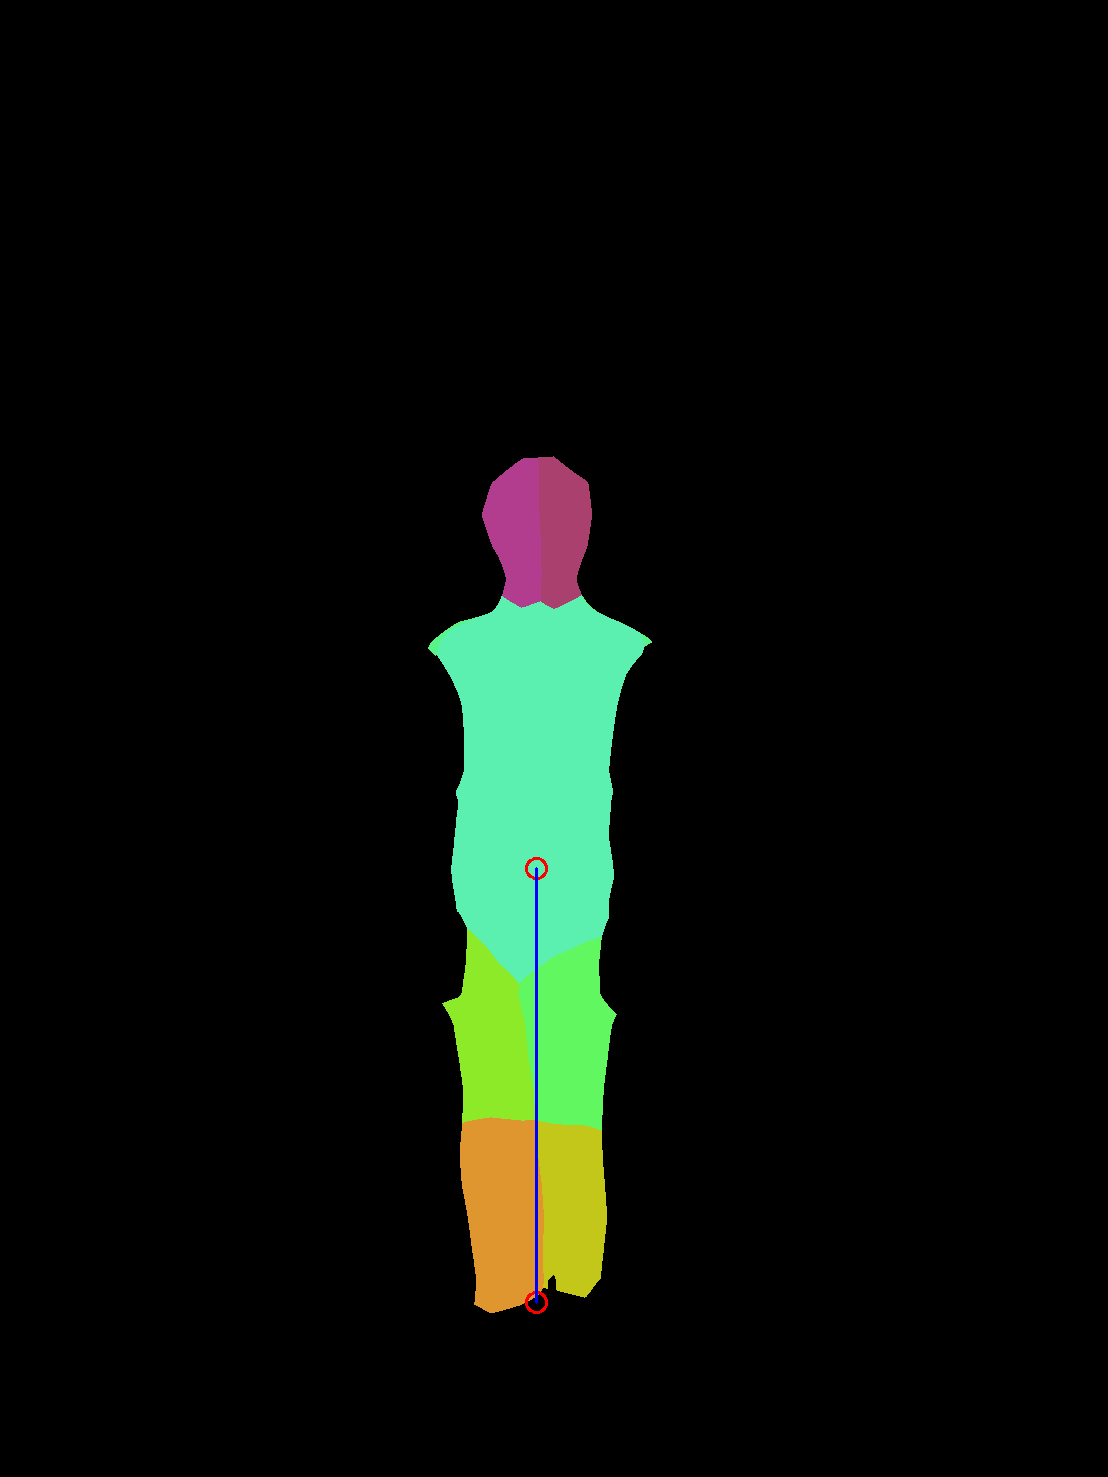

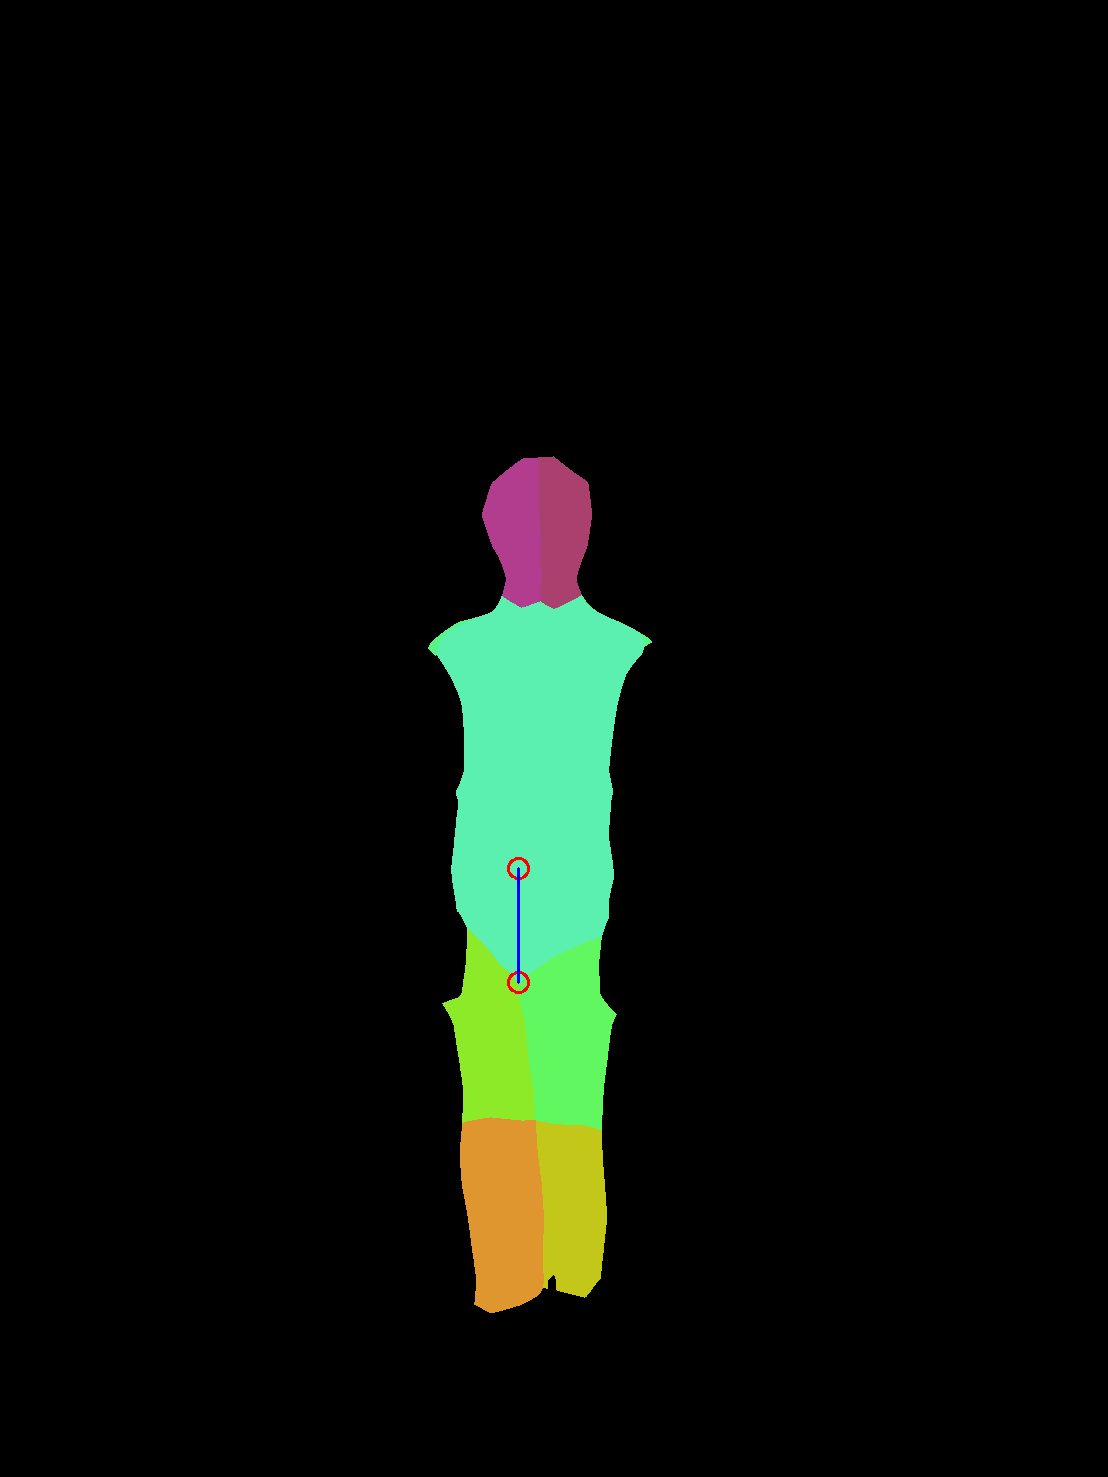

upper leg:  68.79875651682357
hip:  89.18822376464085
waist round:  80.26940138817677
waist to crotch:  22.762277733780447
waist height:  87.37863732443746


In [ ]:
scale = generate_scale("./vale_depan.jpg", 170, "")
scale1 = generate_scale("./vale_samping.jpg", 170, "right")
final_scale = (scale + scale1) / 2

side_leg_width = generate_side_leg("./vale_depan.jpg", "./vale_samping.jpg")
front_leg_width = generate_front_upper_leg_width("./vale_depan.jpg")

print("front leg width: ",front_leg_width)
print("front leg width: ", side_leg_width)
# print(final_scale)

upper_leg_round = 0.5 * math.pi * (side_leg_width + front_leg_width)

waist_height = generate_waist_height("./vale_depan.jpg", "man")

hip_length = generate_hip_width("./vale_depan.jpg")
hip_width = generate_hip_width("./vale_samping.jpg")
hip_round = 0.5 * math.pi * (hip_length + hip_width)

hip = hip_round * final_scale
waist_height = generate_waist_height("vale_depan.jpg", "man")
waist_to_crotch = generate_crotch_waist_height("vale_depan.jpg", waist_height)

print("upper leg: ", (upper_leg_round * final_scale)+6)
print("hip: ", hip)
print("waist round: ", 0.9 * hip)
print("waist to crotch: ", waist_to_crotch * final_scale)
print("waist height: ", waist_height * final_scale)

In [ ]:
def run_measure(image_path_front, image_path_side, height, facing, gender):
  scale = generate_scale(image_path_front, height, "")
  scale1 = generate_scale(image_path_side, height, facing)
  final_scale = (scale + scale1) / 2

  side_leg_width = generate_side_leg(image_path_front, image_path_side)
  front_leg_width = generate_front_upper_leg_width(image_path_front)

  upper_leg_round = 0.5 * math.pi * (side_leg_width + front_leg_width)

  waist_height = generate_waist_height(image_path_front, gender)

  hip_length = generate_hip_width(image_path_front)
  hip_width = generate_hip_width(image_path_side)
  hip_round = 0.5 * math.pi * (hip_length + hip_width)
  hip = hip_round * final_scale

  waist_height = generate_waist_height(image_path_front, gender)
  waist_to_crotch = generate_crotch_waist_height(image_path_front, waist_height)

  print("upper leg: ", (upper_leg_round * final_scale)+6)
  print("hip: ", hip)
  print("waist round: ", 0.9 * hip)
  print("waist to crotch: ", waist_to_crotch * final_scale)
  print("waist height: ", waist_height * final_scale)

1302.9253010685115
1309.7434897105761
masuk sini kan


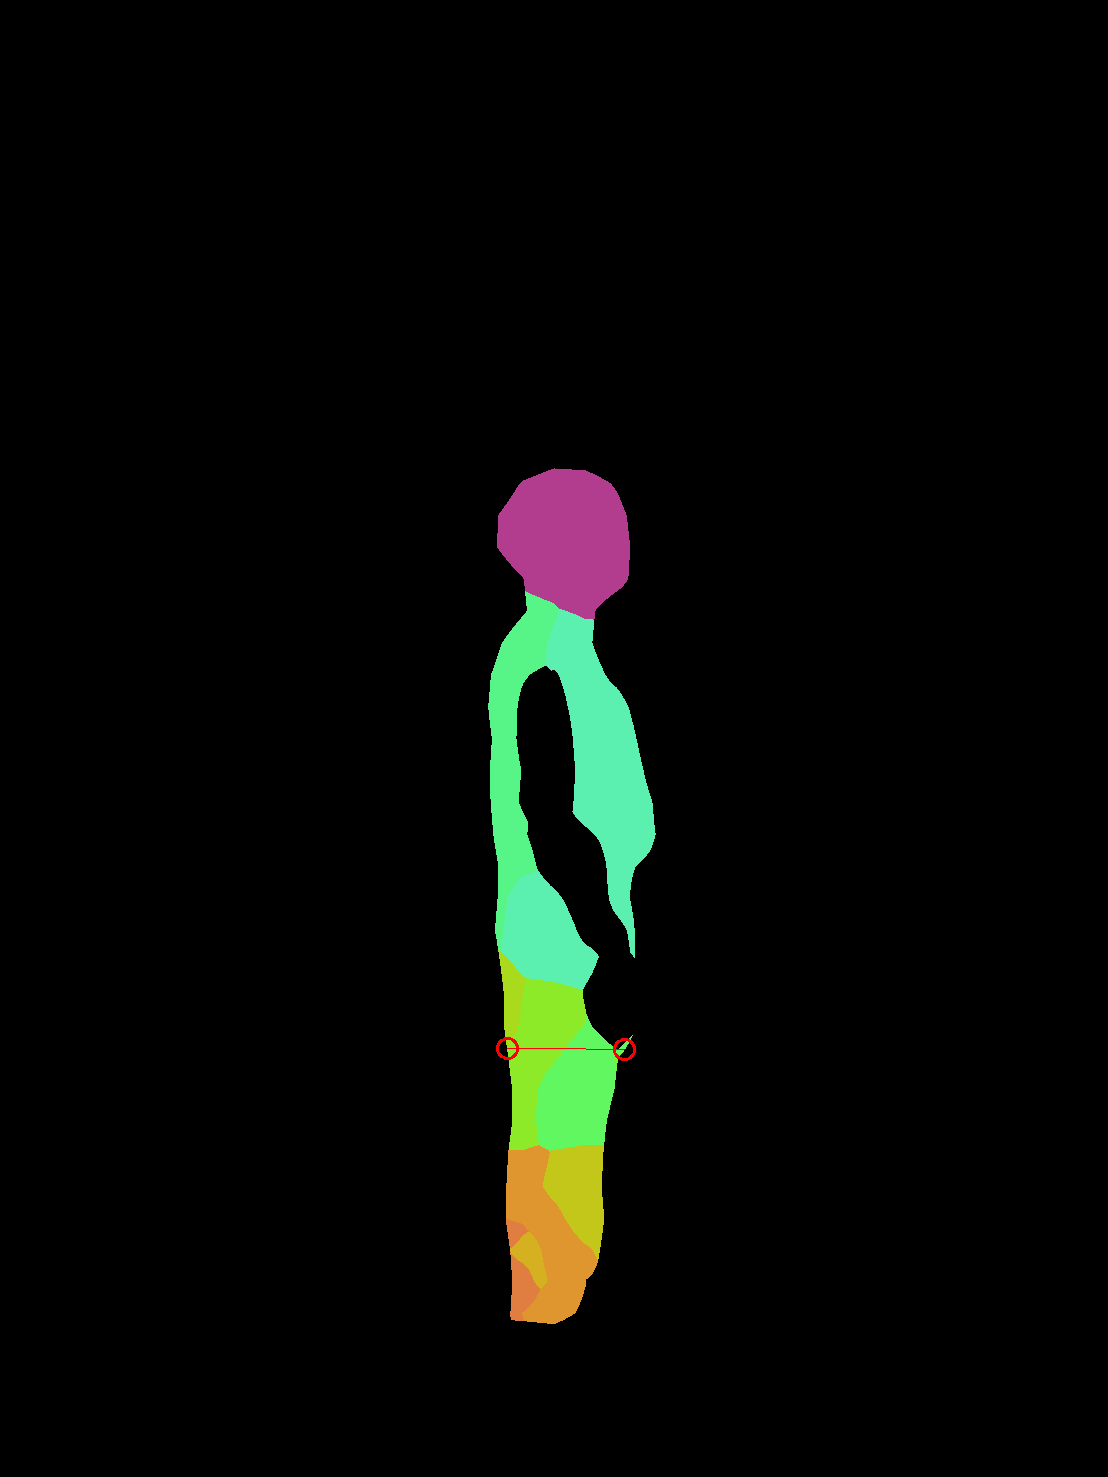

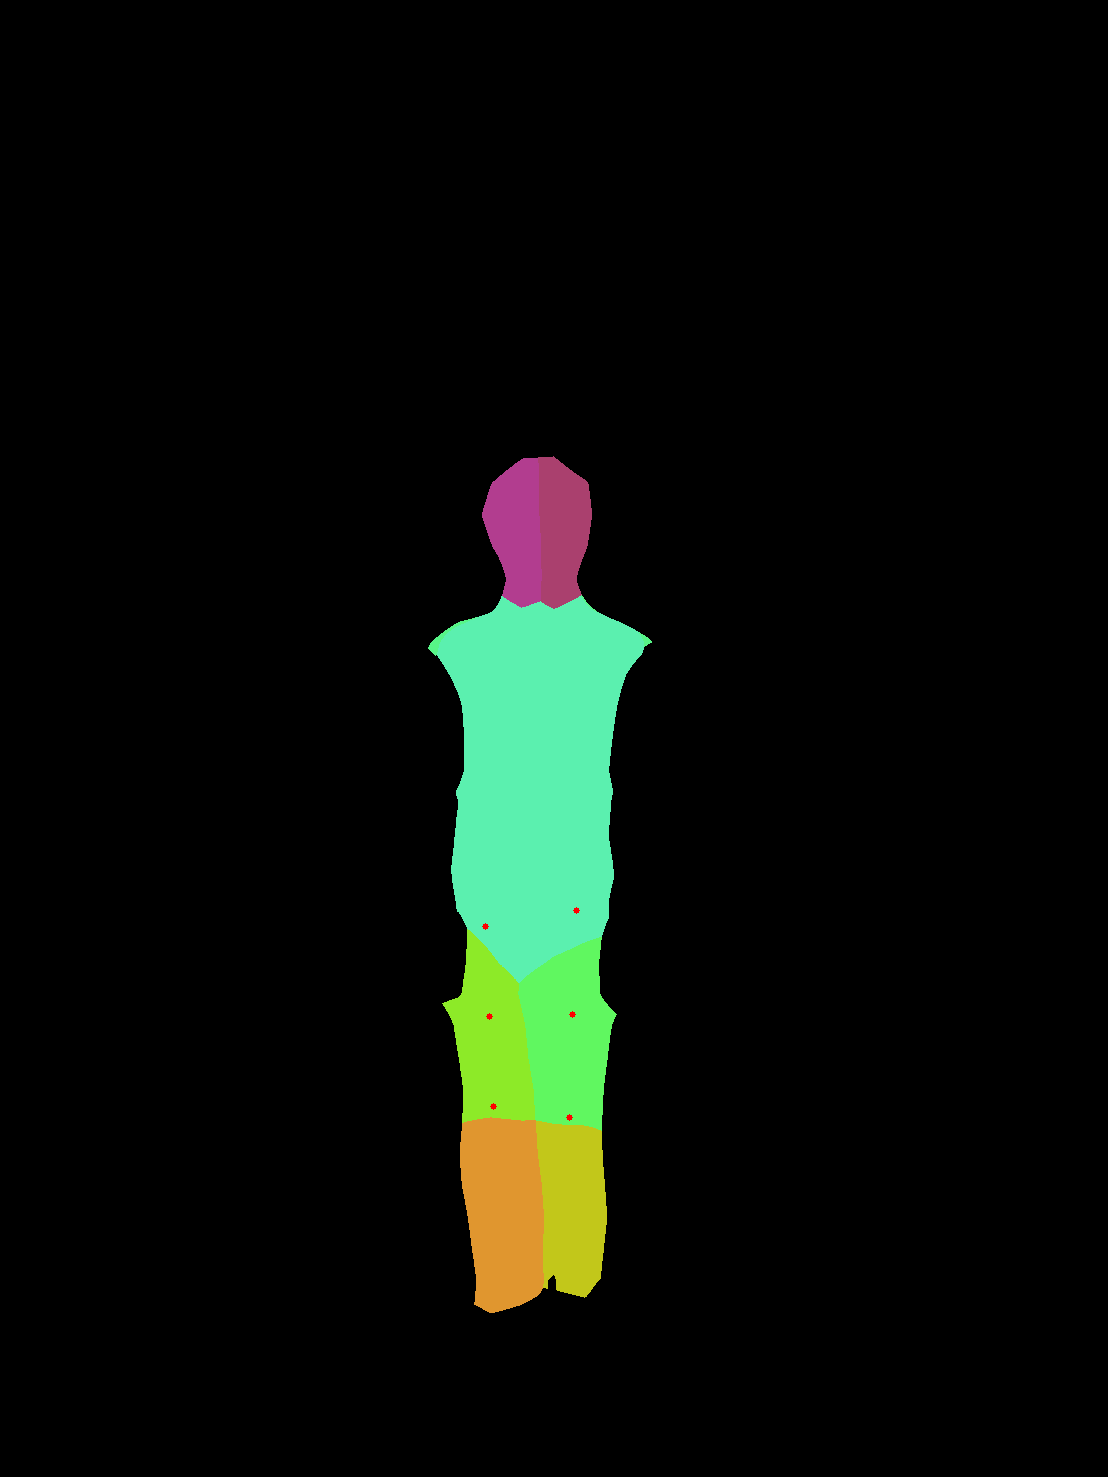

gradien right:  0.04436936015288544
gradien left:  0.036085630875835016


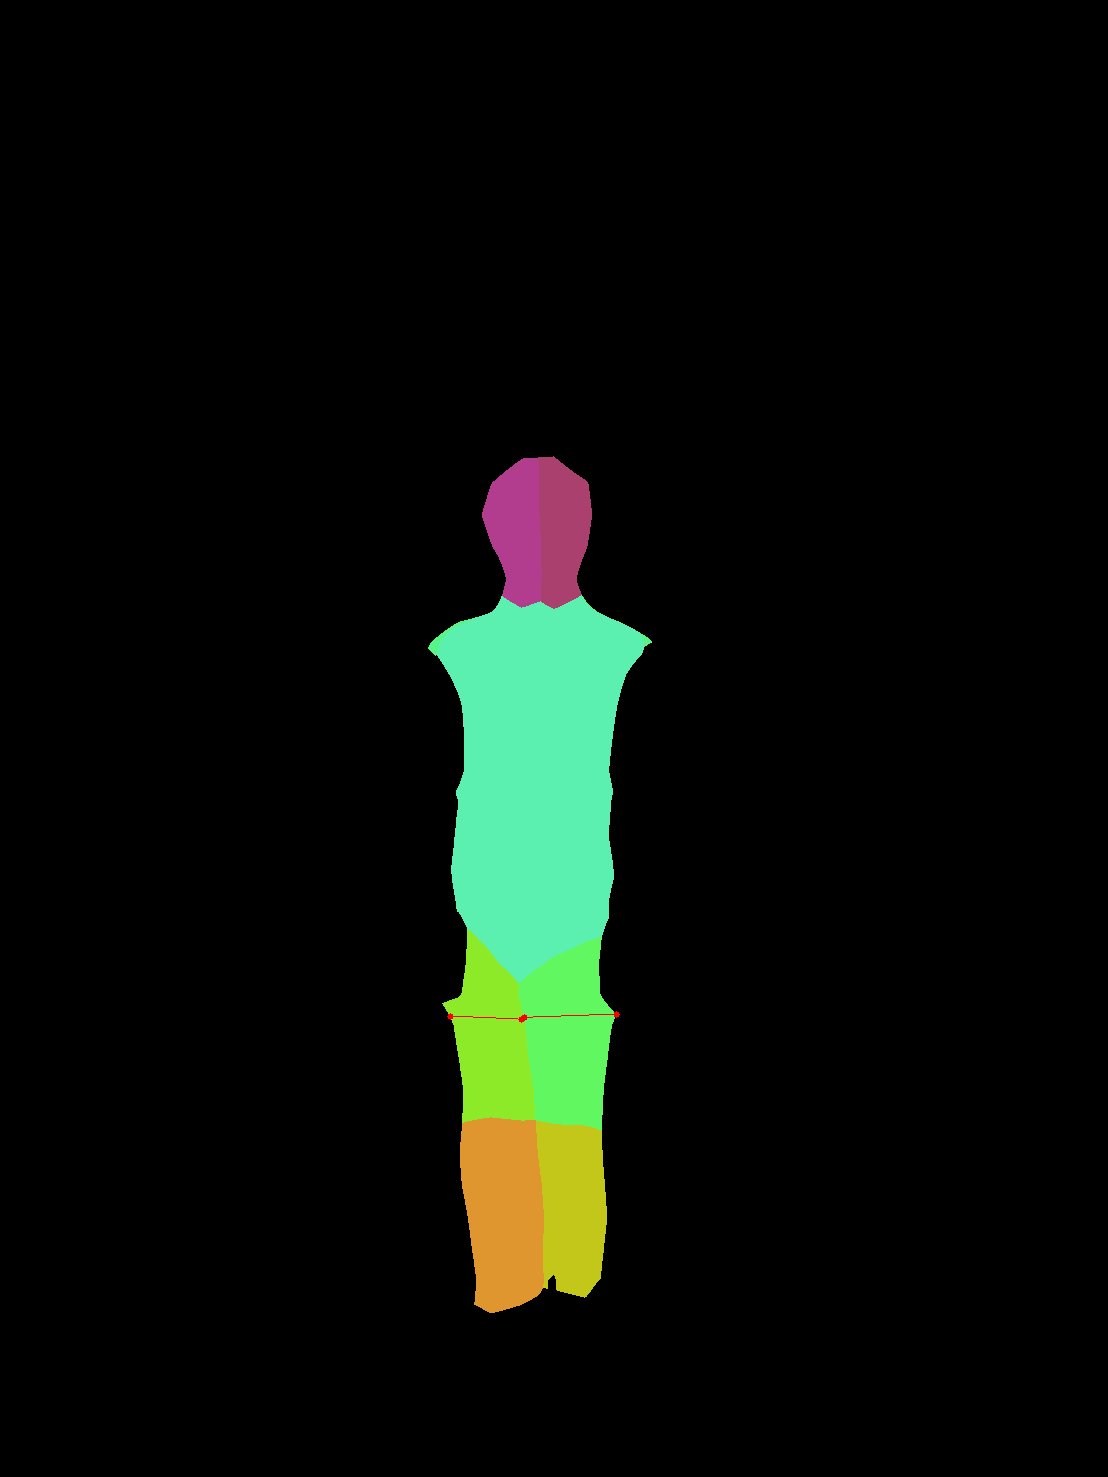

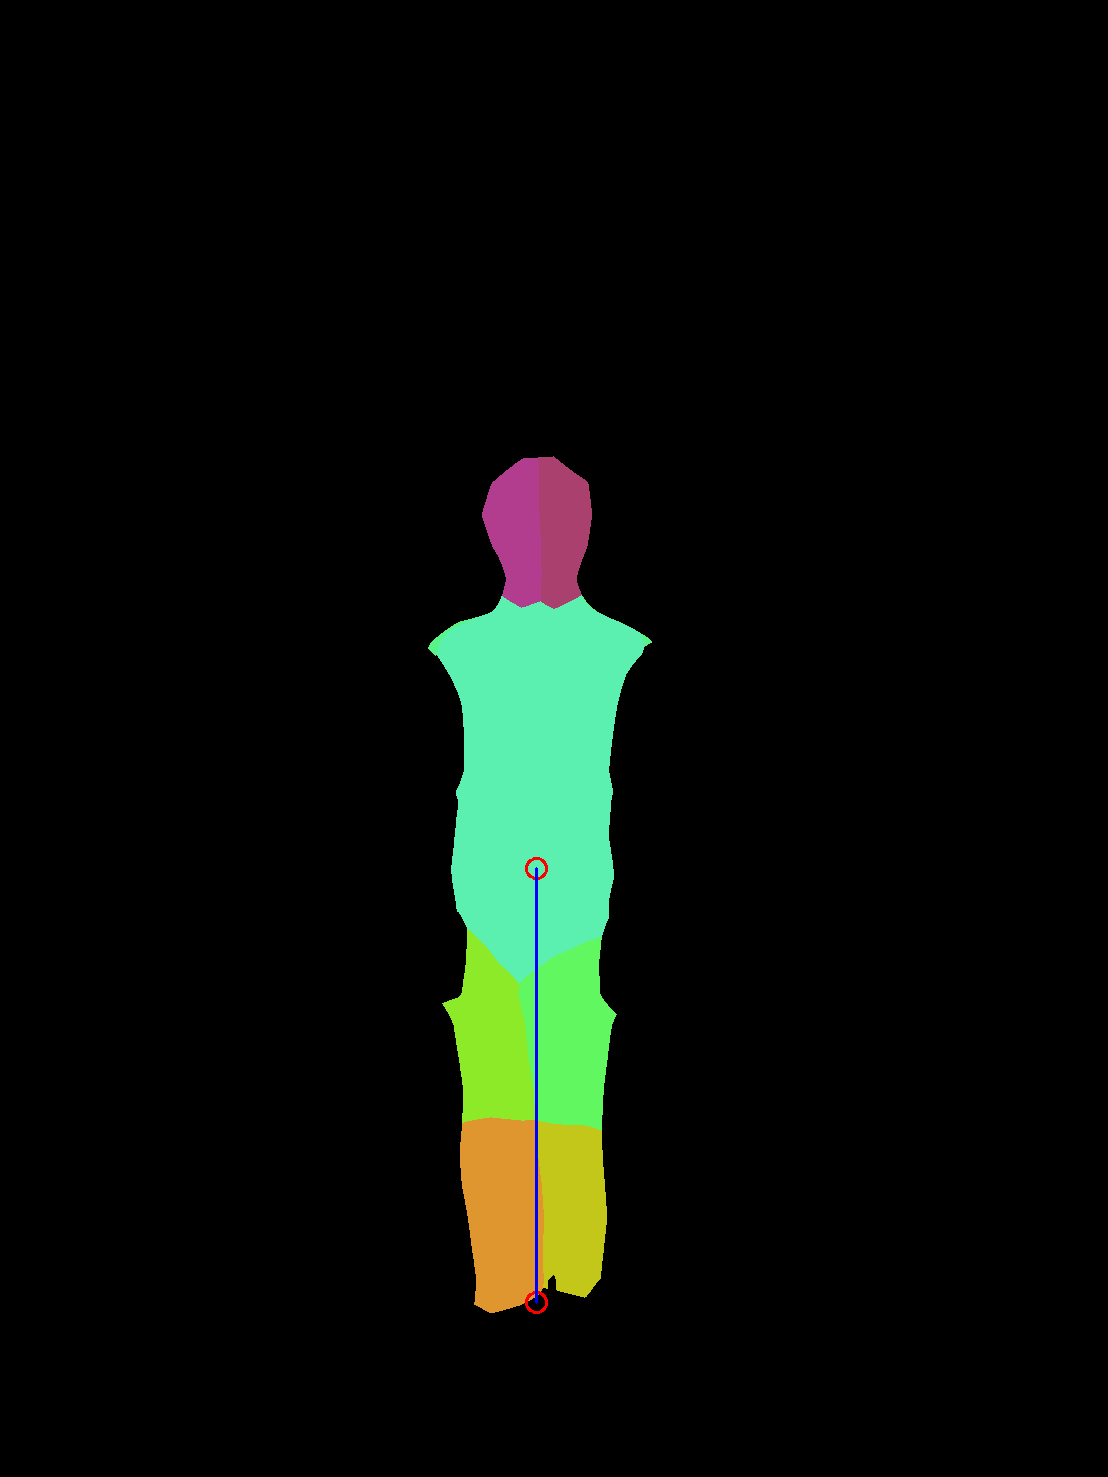

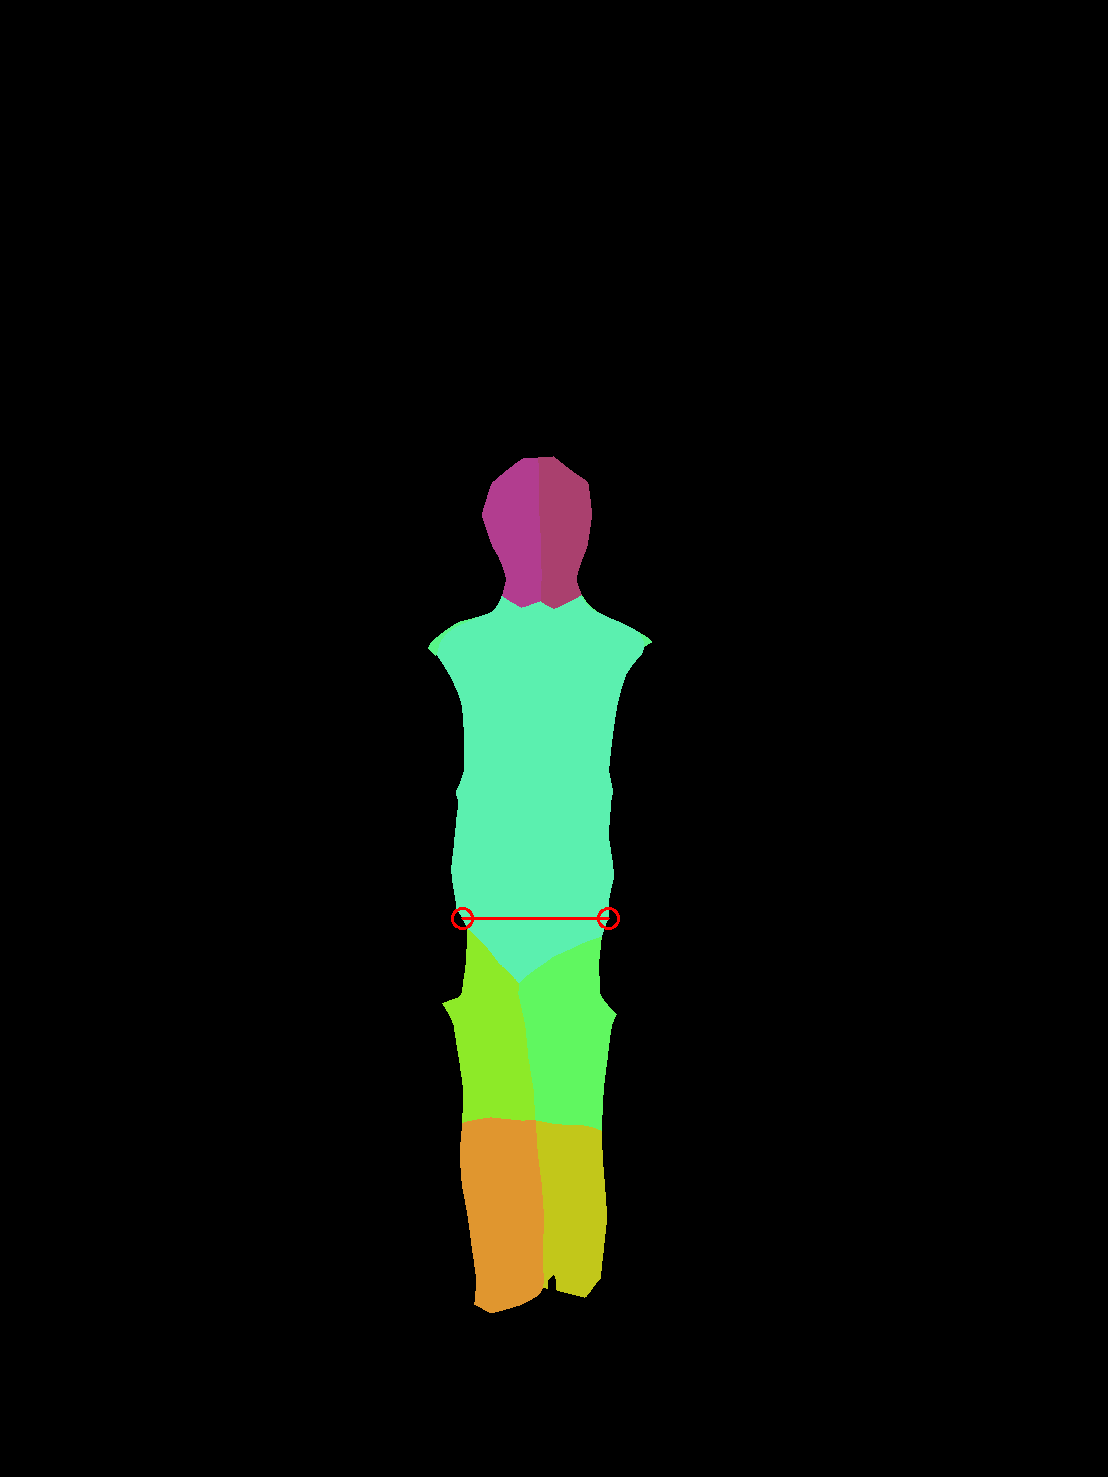

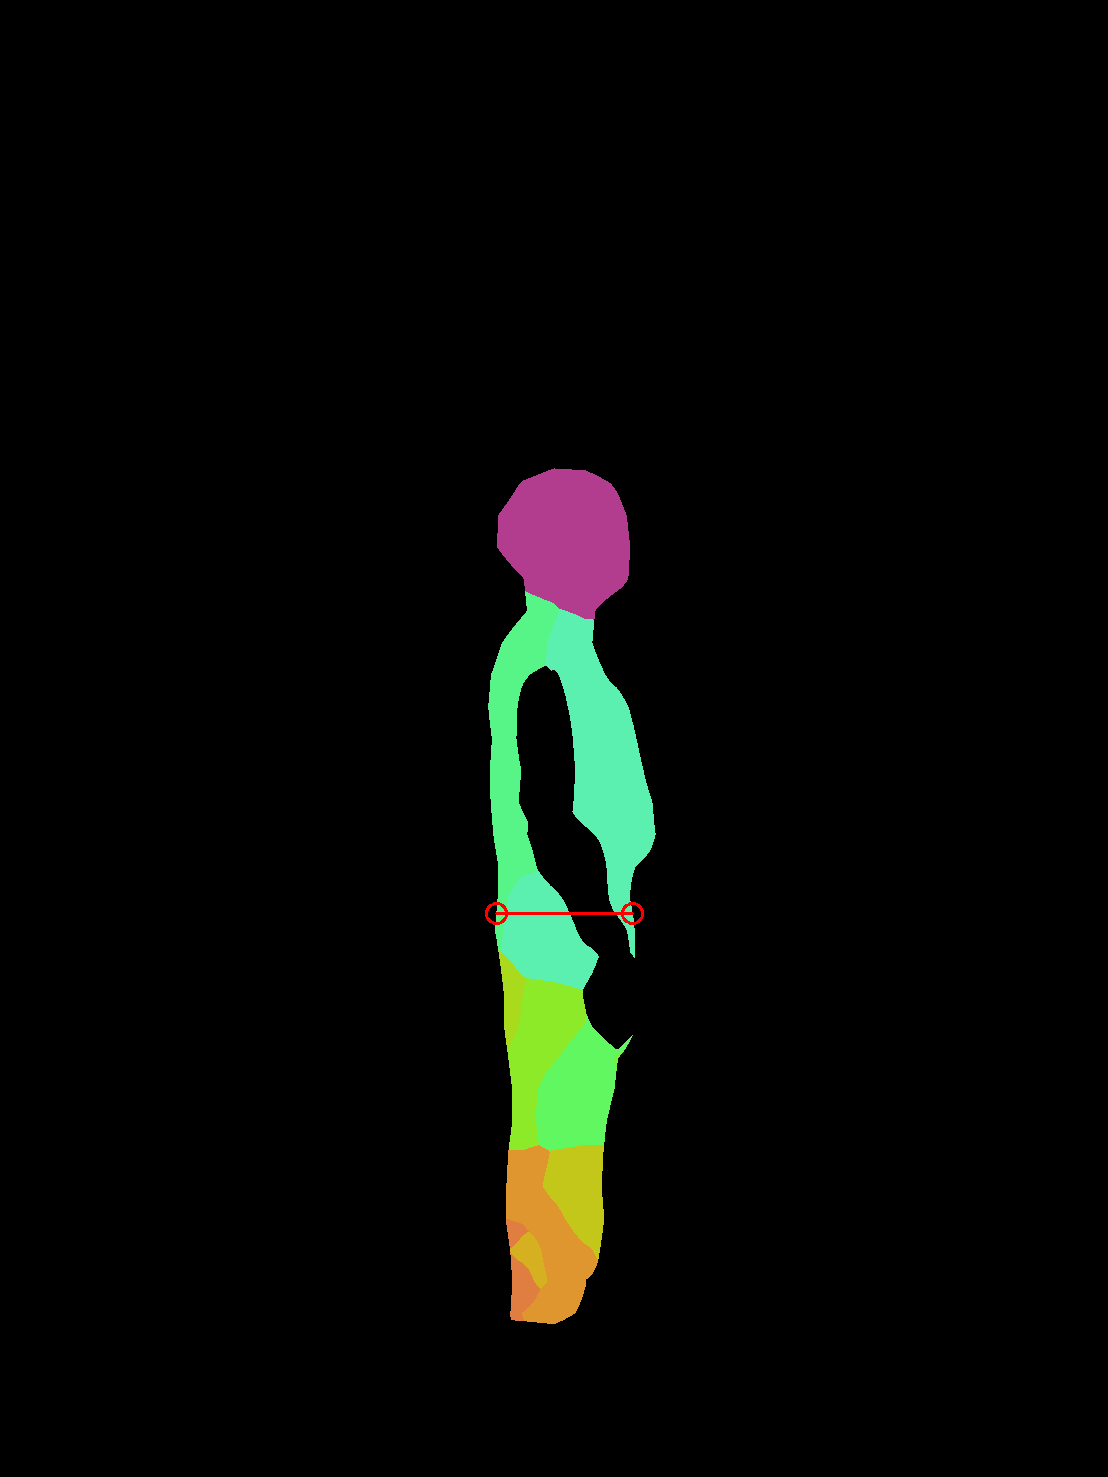

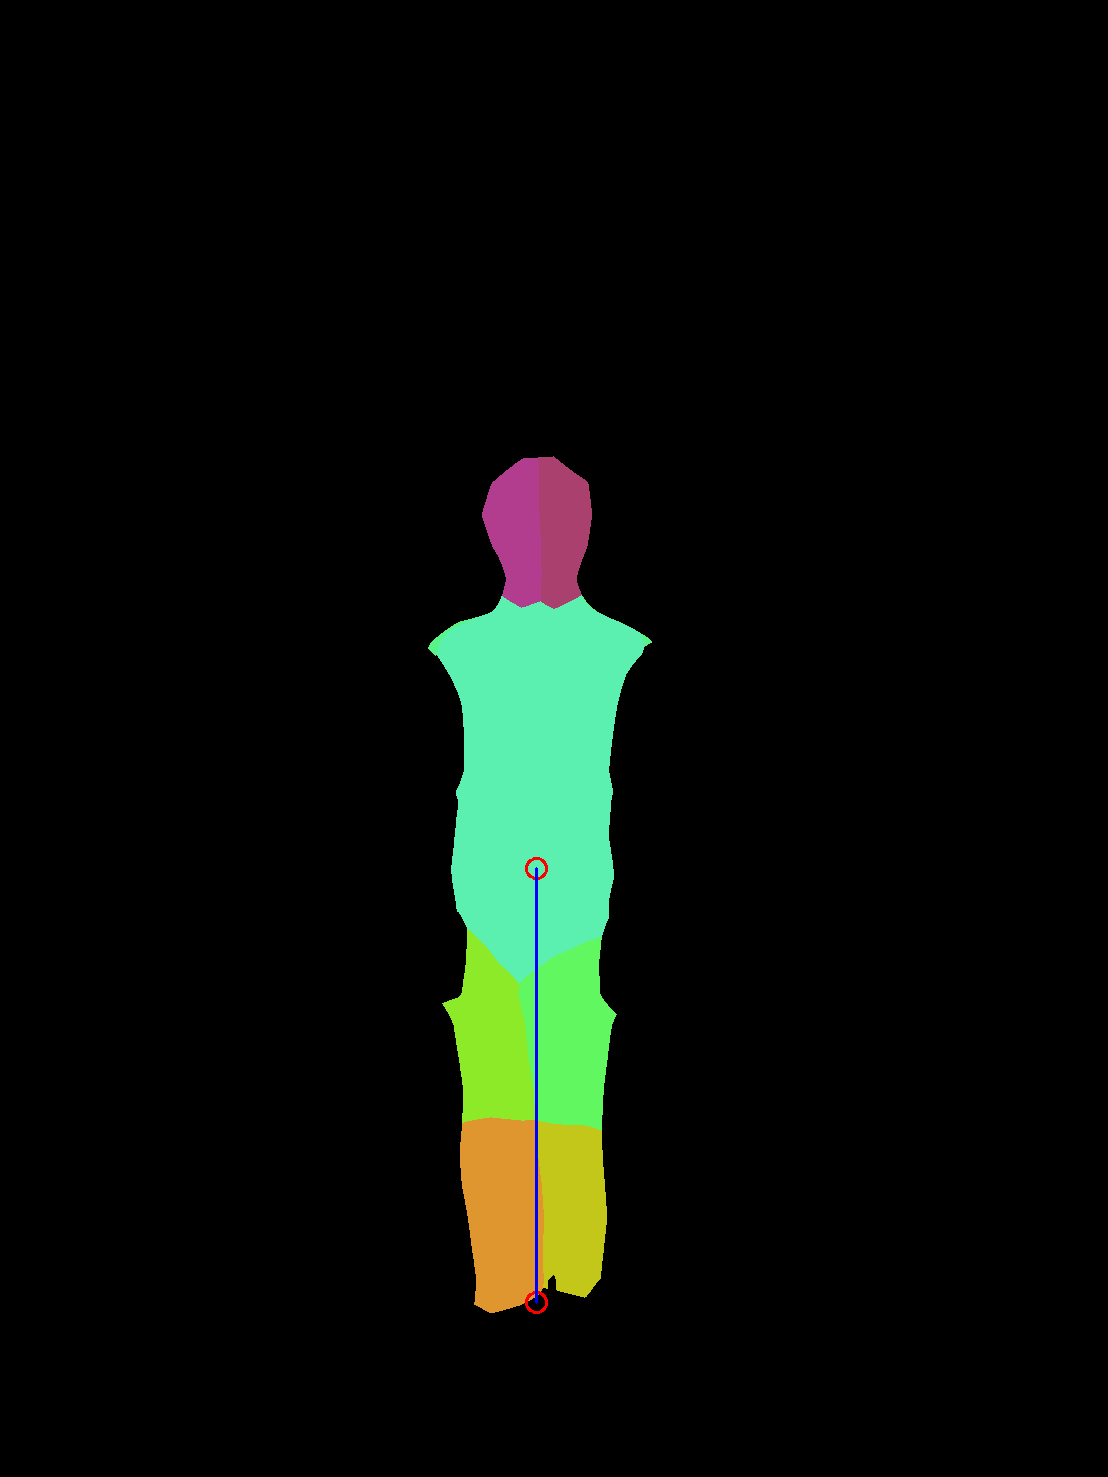

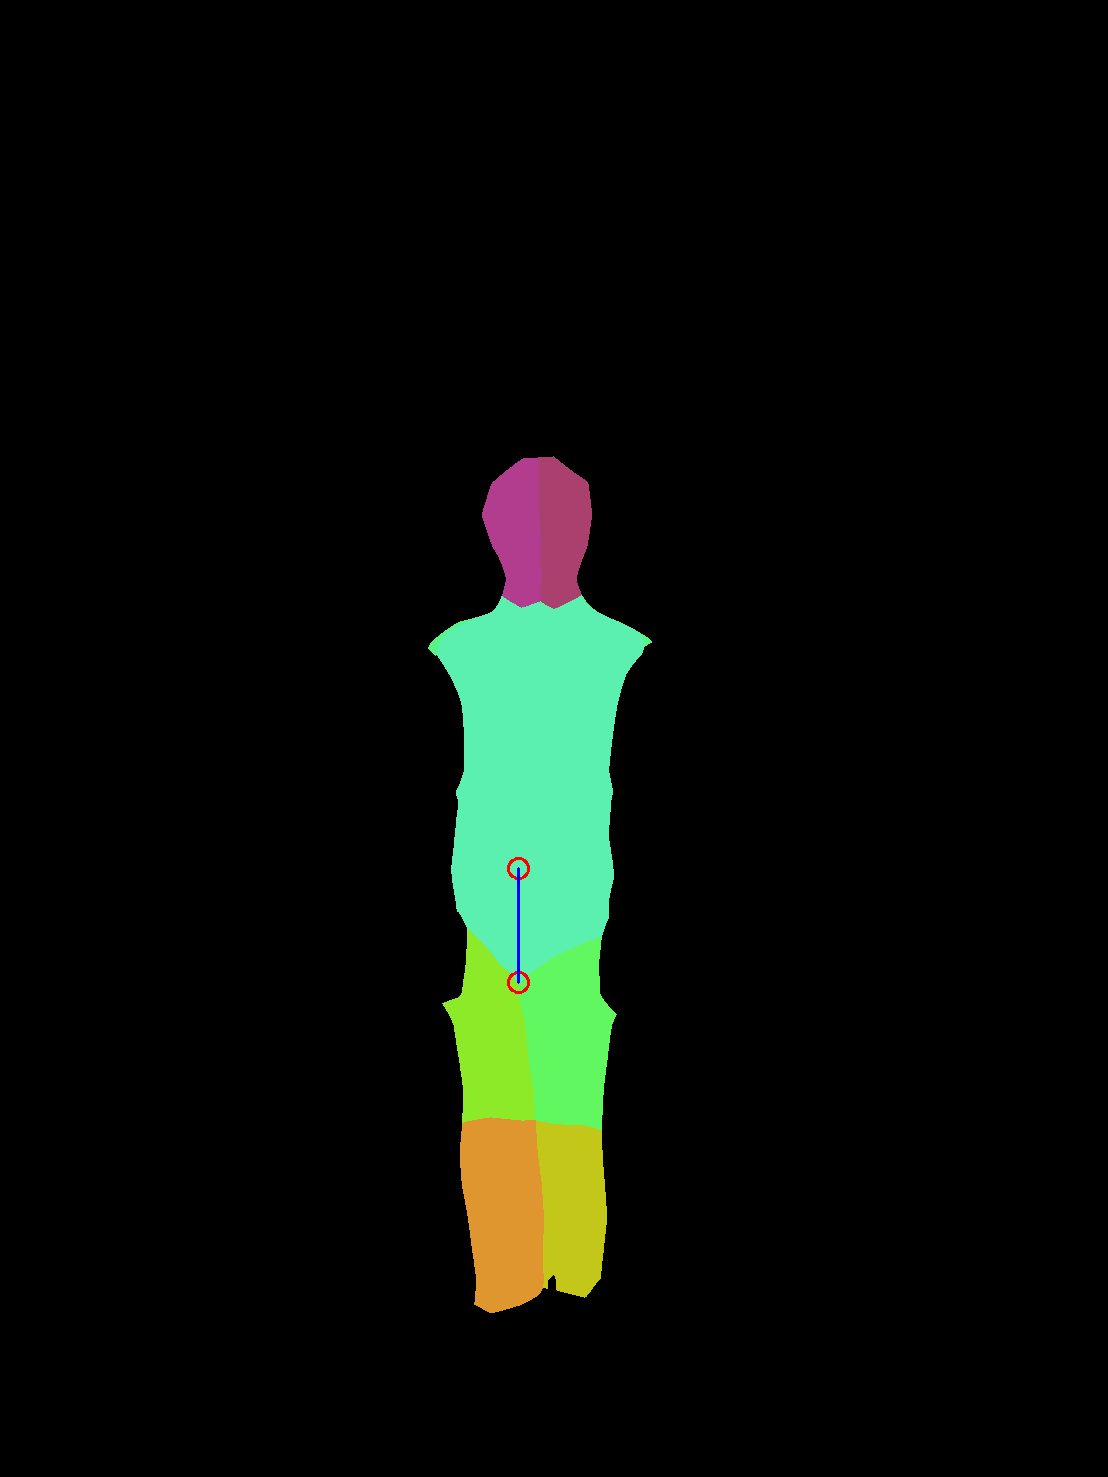

upper leg:  68.79875651682357
hip:  89.18822376464085
waist round:  80.26940138817677
waist to crotch:  22.762277733780447
waist height:  87.37863732443746


In [ ]:
run_measure('./vale_depan.jpg', './vale_samping.jpg', 170, 'right', 'man')


## Experiment

In [ ]:

# preprocessing
## samping
image_side = tf.keras.preprocessing.image.load_img("./samping.jpg")
image_array_side = tf.keras.preprocessing.image.img_to_array(image_side)
result_side = bodypixmodel.predict_single(image_array_side)
## depan
# image_front = tf.keras.preprocessing.image.load_img("./102599_0.jpg")
# image_array_front = tf.keras.preprocessing.image.img_to_array(image_front)
# result_front = bodypixmodel.predict_single(image_array_front)



# masking
mask_side = result_side.get_mask(threshold=0.75).numpy().astype(np.uint8)
mask_front = result_front.get_mask(threshold=0.75).numpy().astype(np.uint8)

# colored_image
image_colored_side = result_side.get_colored_part_mask(mask_side, part_names=body_parts)
image_colored_front = result_front.get_colored_part_mask(mask_front, part_names=body_parts)

# retrieve poses
poses_side = result_side.get_poses()
poses_front = result_front.get_poses()

# colored image with poses
image_with_poses = draw_poses(
    image_colored.copy(),
    poses,
    keypoints_color=(255, 100, 100),
    skeleton_color=(100, 100, 255)
)

#turn background to black
# masked_image = cv2.bitwise_and(image_array , image_array , mask=mask)

# show colored segmentation image with poses line
# cv2_imshow(image_with_poses)

rightHipPosition = poses[0].keypoints[12].position
leftHipPosition = poses[0].keypoints[11].position

print(rightHipPosition)
print(leftHipPosition)

average_x_position = int((rightHipPosition.x + leftHipPosition.x) / 2)
average_y_position = int((rightHipPosition.y + leftHipPosition.y) / 2)

cv2.destroyAllWindows()

FileNotFoundError: [Errno 2] No such file or directory: './samping.jpg'

In [ ]:
# rightHipPosition = poses[0].keypoints[12].position
# leftHipPosition = poses[0].keypoints[11].position

# print(rightHipPosition)
# print(leftHipPosition)

# average_x_position = int((rightHipPosition.x + leftHipPosition.x) / 2)
# average_y_position = int((rightHipPosition.y + leftHipPosition.y) / 2)

# tempx = int(average_x_position)
# tempy = int(average_y_position)
# print(tempx, " : ", tempy)
# image_colored

In [ ]:
img_gray = cv2.cvtColor(image_colored, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(img_gray, 150, 255, cv2.THRESH_BINARY)
# visualize the binary image
cv2_imshow(thresh)
# cv2.waitKey(0)
# cv2.imwrite('image_thres1.jpg', thresh)
cv2.destroyAllWindows()


In [ ]:
if 0 <= tempy < thresh.shape[0]:
    # Find all x-coordinates where the pixel is white (255) at the specified y-coordinate (tempy)
    white_x_positions = np.where(thresh[tempy, :] == 255)[0]

    # Check if there are any white pixels in that row
    if white_x_positions.size > 0:
        # Get the leftmost and rightmost x-coordinates
        leftmost_x = white_x_positions.min()
        rightmost_x = white_x_positions.max()

        # Draw a line on the original image or on the thresholded image (up to your preference)
        image_with_line = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)  # Convert to BGR to draw a colored line
        line_color = (0, 0, 255)  # Red color in BGR
        line_thickness = 2

        # Draw the line from the leftmost to the rightmost white pixel at y = tempy
        cv2.line(image_with_line, (leftmost_x, tempy), (rightmost_x, tempy), line_color, line_thickness)

        # Display or save the result
        cv2_imshow(image_with_line)
        # cv2.waitKey(0)
        cv2.destroyAllWindows()
    else:
        print("No white pixels found on the specified y-coordinate.")
else:
    print("tempy is out of the image bounds.")

In [ ]:
# Define the circle color (red) and radius
average_hip_color = (0, 0, 255)  # Red

circle_radius = 10  # Adjust radius as needed
circle_thickness = -1  # Fill the circle

# Draw circles on the colored image
image_with_circles = image_colored.copy()
cv2.circle(image_with_circles, (int(tempx), int(tempy)), circle_radius, average_hip_color, circle_thickness)

cv2_imshow(image_with_circles)